# Health insurance cross sell prediction with XGBoost

## 1. Problem description

[This dataset](https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction) contains a list of health insurance customers. The "Response" column indicates whether the customer also wanted to use car insurance.

I'll try to build an effective model that predicts this decision using XGBoost, Optuna hyperparameters tuning, feature encoding, feature selection and few other tricks. First I'll do some classic (non-ML) data analysis and later I'll try to go a little deeper into how the model works.

In [1]:
from articlecommon import *
import warnings
warnings.filterwarnings("ignore")


print("Number of rows:", df.shape[0])
df.head()

Number of rows: 381109


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 2. Initial data visualization, columns explanation, EDA

I'll do some simple data analysis without Machine Learning models - using various types of plots and elementary mathematical operations.

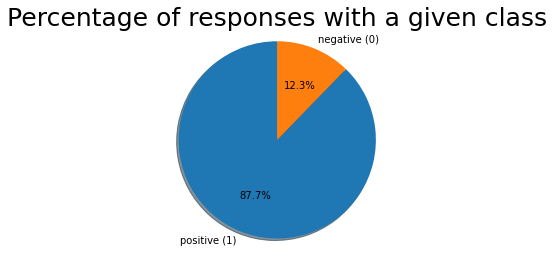

In [2]:
labels = ["positive (1)", "negative (0)"]
negative = df[df.Response == 0].size
positive = df[df.Response == 1].size
sizes = [negative, positive]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Percentage of responses with a given class", fontsize=25)
plt.show()

People who choose both insurances highly outnumber those who do not (87,7%). It's an important information - it's type of "imbalanced dataset". I need to use specific tools for it.

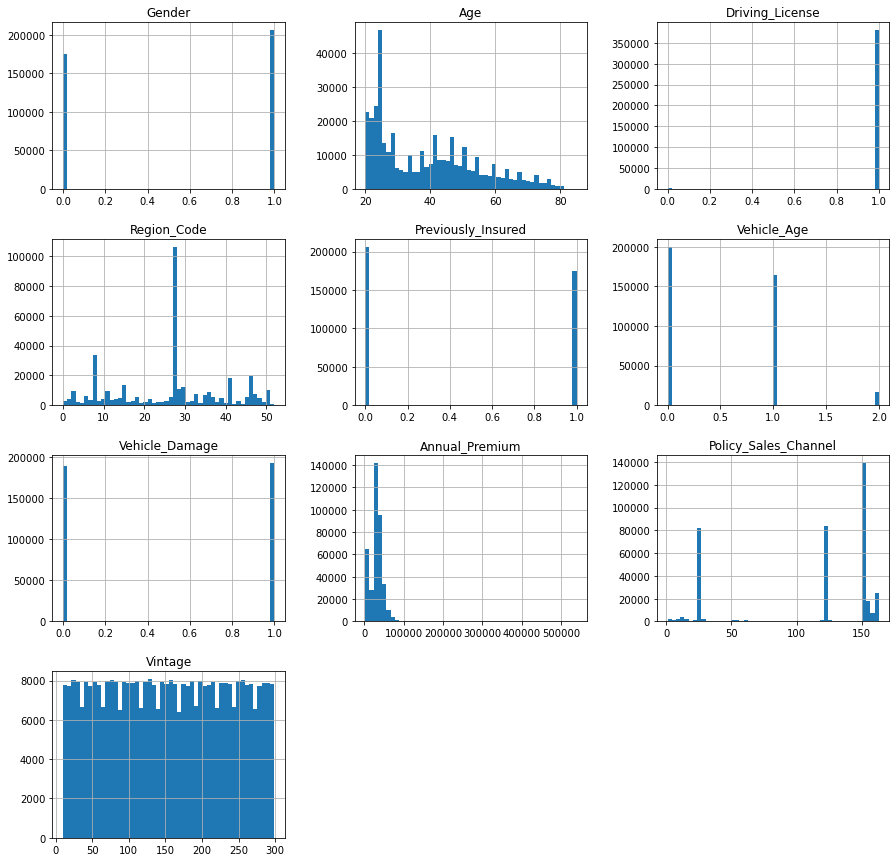

In [3]:
X_le.hist(bins=50, figsize=(15, 15))
plt.show()

1. ***Gender*** - there are slightly more males than females.
2. ***Age*** - the majority of people are between the ages of 20 and 30. There is also a second, smaller peak around the age of 45.
3. ***Driving_License*** - the vast majority of customers have a driver's license.
4. ***Region_Code*** - some regions have many more customers than others.
5. ***Previously_Insured*** - this column indicates whether or not a customer has insurance (0 = no, 1 = yes). 54% don't have one.
6. ***Vehicle_Age*** - most people have young cars (less than 1 year old), slightly fewer in the 1-2 year range, and noticeably fewer over 2 years old.
7. ***Vehicle_Damage*** - a similar proportion of customers have a car with and without damage.
8. ***Annual_Premium*** - this feature describes "the amount customer needs to pay as premium in the year". The column resembles most data with salaries - it has a long "right tail".
9. ***Policy_Sales_Channel*** - there is no detailed description of the specific values of this column. Some sales channels are orders of magnitude more likely to be used than others.
10. ***Vintage*** - "number of days, customer has been associated with the company. The column has very even distribution - the company most likely received a similar number of customers throughout the year.

### 2.1 Mutual information
Mutual information is a tool for measuring the dependence between two variables. It uses the "K nearest neighbors" algorithm to describe it. If you want to expand your knowledge, look at the sklearn MI [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html)

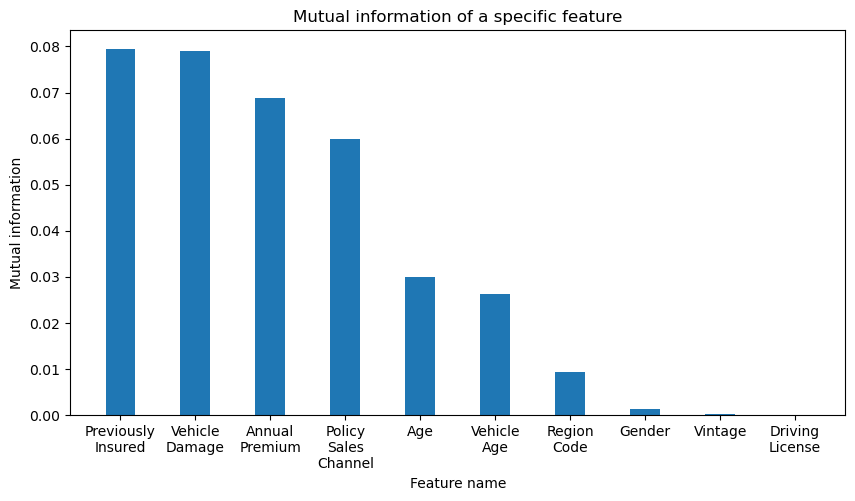

In [2]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_le, y, random_state=42, discrete_features=[0, 1, 2, 3, 4, 5, 6, 7, 9])

data = pd.Series(mi, name="MI Scores", index=X_le.columns).sort_values(ascending=False)

def underscore_to_space(text):
    return text.replace("_", "\n")

region_code = list(  map(underscore_to_space, data.index.tolist())   )
customers = list(data.values.tolist())

fig = plt.figure(figsize = (10, 5))
plt.bar(region_code, customers,
        width = 0.4)
 
plt.xlabel("Feature name")
plt.ylabel("Mutual information")
plt.title("Mutual information of a specific feature")
plt.show()

### 2.2 KDE plots

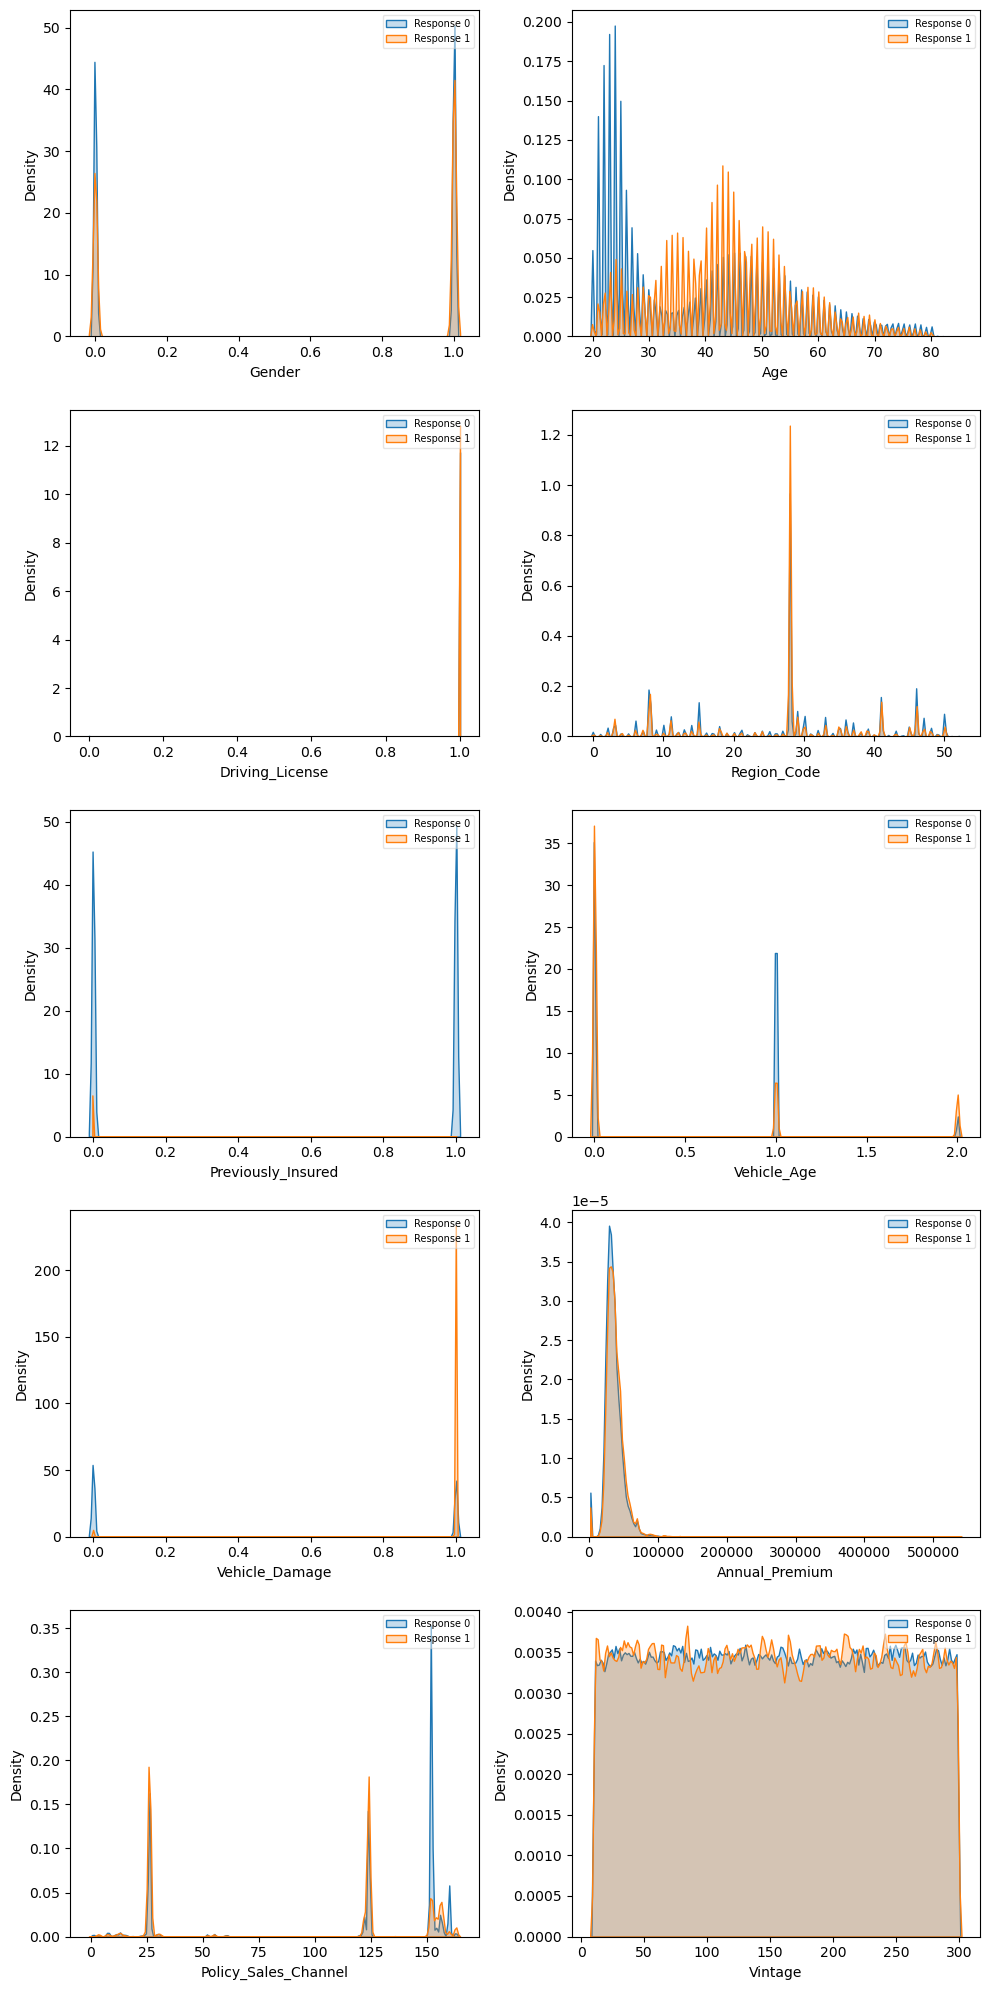

In [6]:
import matplotlib.pyplot as plt
import math
import seaborn as sns
dfresponse0 = df_le[df_le["Response"] == 0]
dfresponse1 = df_le[df_le["Response"] == 1]

cols = df_le.drop(columns='Response').columns

height = 5
width = math.ceil(len(cols) / height)

fig, ax = plt.subplots(height, width, figsize=(10,20))
index=0
for columnX in cols:
    sns.kdeplot(data=dfresponse0[columnX], label="Response 0", shade=True, ax=ax[index//width][index % width], bw_adjust=0.1)
    sns.kdeplot(data=dfresponse1[columnX], label="Response 1", shade=True, ax=ax[index//width][index % width], bw_adjust=0.1)
    ax[index//width][index % width].legend(loc='best', prop={'size': 7}, fancybox=True, framealpha=0.5)
    index+=1

fig.tight_layout()
plt.show()

1. Gender - at first glance, we can see that a higher percentage of men (label 1) opt for car insurance. The relationship is noticeable, but not very strong.
2. Age - young people are usually not interested in the service, the most frequent users are those aged 40-50. Among people of a particular age the relationship is quite strong - the percentage can vary as much as 3-4 times. In some ranges, however, the difference is not large - for example, around the age of 30.
3. Region_Code - people in certain regions have a much higher or lower percentage of service users, but it is also important to keep in mind how regions vary in the total number of customers.
4. Previously_Insured - people with insurance usually do not want to buy a new one, contrary to people without insurance. The relationship is very strong.
5. Vehicle_Age (0 - '1-2 Year', 1 - '< 1 Year', 2 - '> 2 Years') - people prefer to insure old cars over new ones.
6. Vehicle_Damage 0 - 'no', 1 - 'yes' - we can see that damaged cars have a much higher percentage of insurance.
7. Annual_Premium - it's difficult to determine from the raw data, it is better to present a second graph with the logarithm of the feature.
8. Policy_Sales_Channel - insurance percentages can vary widely for specific sales channels.
9. Vintage - this feature is unlikely to affect the outcome.

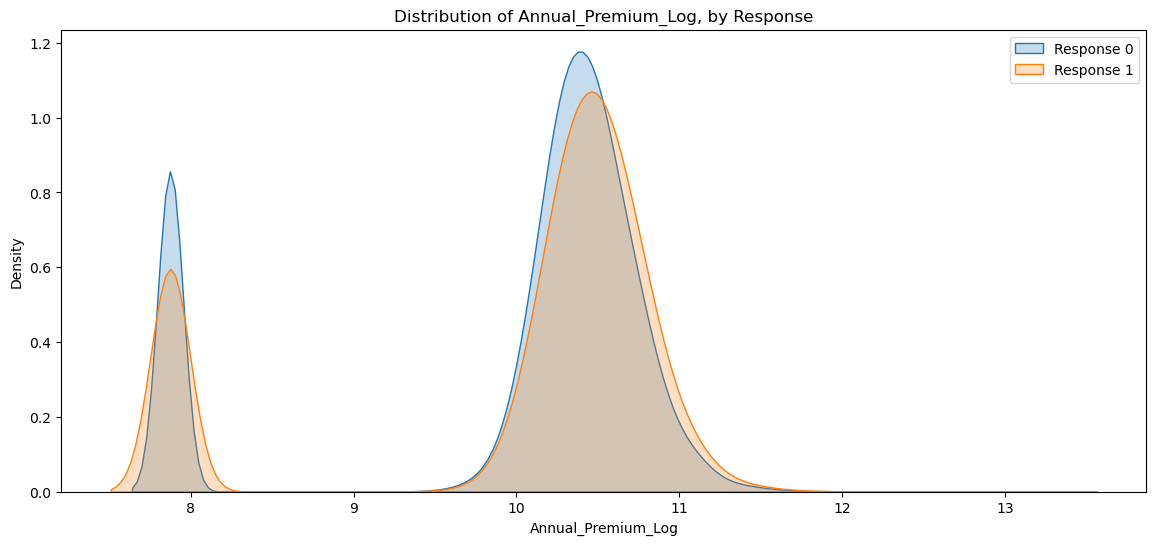

In [29]:
df_log = df_le[['Annual_Premium', 'Response']].copy()
df_log['Annual_Premium_Log'] = np.log(df['Annual_Premium'])

dfresponse0 = df_log[df_log["Response"] == 0]
dfresponse1 = df_log[df_log["Response"] == 1]

plt.figure(figsize=(14,6))
sns.kdeplot(data=dfresponse0['Annual_Premium_Log'], label="Response 0", shade=True)
sns.kdeplot(data=dfresponse1['Annual_Premium_Log'], label="Response 1", shade=True)

plt.title("Distribution of Annual_Premium_Log, by Response")
plt.legend()
plt.show()

Here we can see, that Annual_Premium affects output. It's not so easy to describe, but model probably will be able to use this information properly.

### 2.3 initial analysis summary
Previously_Insured and Vehicle_Damage are very important features - both techniques (KDE plots and mutual information) confirm that. It is necessary to encode Region_Code and Policy_Sales_Channel before drawing deeper conclusions.

## 3. Basic model with logistic regression
First, I'll build a quite simple model. It will enable me to check if my next steps improve the result. Logistic regression is one of the least complex algorithms, so it'll be my initial try.

### 3.1 Metric
This problem is an example of an "imbalanced dataset". It means that one class ("negative" or "zero" in this article) has significantly more samples than the others. You can get 87.7% accuracy... just by assigning the same prediction to all cases! There are more reliable metrics for imbalanced datasets - one of them is ROC AUC.

#### 3.1.1 True positive rate, False positive rate
For a proper understanding of the ROC AUC metric, it is necessary first to explain TPR (true positive rate) and FPR (false positive rate).

The "true positive rate" is the number of properly predicted positive cases divided by all positive cases. For example, if there are 10.000 customers who chose insurance and our model found 9.500 of them - TPR equals 9.500/10.000 = 95%.

The "false positive rate" is the number of falsely predicted positive cases divided by all negative cases. For example, if there are 100.000 customers who didn't choose insurance and our model predicted that 1.000 of them would choose it, the FPR equals 1.000/100.000 = 1%.

#### 3.1.2 Receiver operating characteristic
Usually we can set a threshold describing how sure the algorithm needs to be to predict the result for a single sample as "true". There is TPR on the vertical axis and FPR on the horizontal axis, and the ROC curve is created by plotting points for consecutive thresholds.

#### 3.1.3 ROC Area under curve
It could be hard to simply compare various ROC curves. For this purpose, I'll use the final metric, the ROC AUC (area under the curve). The algorithm will calculate the area under the ROC curve - it's much easier to compare single numbers.


### 3.2 Cross validation
Cross validation is a way of measuring model performance. It divides all the data into a given number of parts. Later in each iteration, one part is used as validation data and the rest as training data. Each part was used as test data after all iterations. This method gives more reliable measurements than standard one-step validation.

In [4]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42, n_jobs=-1)
cross_val_summary(logreg, X_le, y)

Cross validation time: 21.34451174736023 seconds
Mean score: 0.6626219144051005


## 4. Simple model with Light GBM
LightGBM is much more complex algorithm originally created by Microsoft. Explaining of the main idea is too long for this article, but in general it's tree-based model. I encourage you to ckeck [this article](https://towardsdatascience.com/what-makes-lightgbm-lightning-fast-a27cf0d9785e).

In [3]:
lgbm = LGBMClassifier(random_state=42, verbose=-1)
cross_val_summary(lgbm, X_le, y)

Cross validation time: 3.9938089847564697 seconds
Mean score: 0.8575017665775645


The result is ***much*** higher with a lower execution time. Now I'll try to improve a little the performance of this algorithm - first by modifying the input data.

## 5 Remove 'Vintage' column

As I said in one of the previous steps, it looks like the feature "Vintage" really cannot add any relevant information to the model. Let's check the result after dropping this column:

In [6]:
cross_val_summary(lgbm, X_le.drop(columns="Vintage"), y, message="Mean ROC_AUC without 'Vintage' column: ")

Cross validation time: 3.272094249725342 seconds
Mean ROC_AUC without 'Vintage' column: 0.8577693288099889


ROC_AUC is slightly higher and calculations are about 12% faster. From now on, I won't use this feature in any model.

I tried to extract more specific information from 'Vintage' feature, such as day of the week, month etc., but it didn't help one bit.

## 6. StandardScaler vs PowerTransformer vs QuantileTransformer

Tree-based algorithms handle non-scaled data quite well, but we can still check how various scaling and transforming methods affect the model.

In [4]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer

def compare_preprocessing(model, X, y):
    scaler = StandardScaler()
    transformer = PowerTransformer()
    scaler_without_std = StandardScaler(with_std=False)
    quant_trans_uniform = QuantileTransformer(output_distribution='uniform')
    quant_trans_normal = QuantileTransformer(output_distribution='normal')

    model_scaler = make_pipeline(scaler, model)
    model_transformer = make_pipeline(transformer, model)
    model_scaler_transformer = make_pipeline(scaler_without_std, transformer, model)
    model_quant_trans_uniform = make_pipeline(quant_trans_uniform, model)
    model_quant_trans_normal = make_pipeline(quant_trans_normal, model)

    cross_val_summary(model, X, y, message="Mean ROC_AUC score without scaler: ")
    cross_val_summary(model_scaler, X, y, message="Mean ROC_AUC score with scaler: ")
    cross_val_summary(model_transformer, X, y, message="Mean ROC_AUC score with transformer: ")
    cross_val_summary(model_scaler_transformer, X, y, message="Mean ROC_AUC score with scaler and transformer: ")
    cross_val_summary(model_quant_trans_uniform, X, y, message="Mean ROC_AUC score with QuantileTransformer (uniform distribution): ")
    cross_val_summary(model_quant_trans_normal, X, y, message="Mean ROC_AUC score with QuantileTransformer (normal distribution): ")

compare_preprocessing(lgbm, X_le.drop(columns="Vintage"), y)

Cross validation time: 3.6312735080718994 seconds
Mean ROC_AUC score without scaler: 0.8577693288099889
Cross validation time: 3.7606070041656494 seconds
Mean ROC_AUC score with scaler: 0.8574143509437648
Cross validation time: 19.10138201713562 seconds
Mean ROC_AUC score with transformer: 0.8577319376846066
Cross validation time: 23.048712015151978 seconds
Mean ROC_AUC score with scaler and transformer: 0.8577400779770201
Cross validation time: 6.006200075149536 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8576643396361232
Cross validation time: 7.348038673400879 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8577167379214481


The differences between various scaling methods are small, so I need to make more tests after the next steps.

## 8. Policy_Sales_Channel One Hot Encoding

"Policy_Sales_Channel" is a categorical column. Algorithms cannot always effectively use this type of data in a single column. For example, channel 2 is not "smaller" than channel 4, and channel 3 is not "between" them in a mathematical sense. There are some tools for addressing this problem. For now, I'll use One Hot Encoding. It creates a new column for each of the categories and fills it with 1 if the sample falls into that category and with 0 if it does not.

In [5]:
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")
X_le_psc = pd.concat([X_le, psc_ohe], axis=1)
compare_preprocessing(lgbm, X_le_psc.drop(columns="Vintage"), y)

Cross validation time: 7.753028392791748 seconds
Mean ROC_AUC score without scaler: 0.8574873160321502
Cross validation time: 16.76096510887146 seconds
Mean ROC_AUC score with scaler: 0.8577947969646201
Cross validation time: 295.85020327568054 seconds
Mean ROC_AUC score with transformer: 0.8577408859764913
Cross validation time: 403.7041118144989 seconds
Mean ROC_AUC score with scaler and transformer: 0.8575996426275662
Cross validation time: 24.417264938354492 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8576919569781671
Cross validation time: 34.815454721450806 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8575866105724133


Some of the results are higher, while some are worse. Training time has increased significantly. I tested it, and the performance with the original Policy_Sales_Channel column removed is even worse.

So... Why the algorithm can't effectively use new features?
Unfortunately, there are 155 distinct categories. Given the nearly 400.000 samples and complex algorithm, this step significantly slows down training. Furthermore, it generates a large number of columns with a few "ones" and several hundred thousand "zeroes". Such columns provide a lot of noise but little meaningful information.

How can we curb this problem?

If a given policy sales channel occurs only once in the whole dataset, it can't be used to predict other samples. At first, I will eliminate such categories.

In [6]:
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()
counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)
compare_preprocessing(lgbm, X_le_psc.drop(columns="Vintage"), y)

Cross validation time: 6.6485631465911865 seconds
Mean ROC_AUC score without scaler: 0.8574873160321502
Cross validation time: 15.803345680236816 seconds
Mean ROC_AUC score with scaler: 0.8577947969646201
Cross validation time: 279.7007312774658 seconds
Mean ROC_AUC score with transformer: 0.8577408859764913
Cross validation time: 388.281920671463 seconds
Mean ROC_AUC score with scaler and transformer: 0.8575996426275662
Cross validation time: 25.3707914352417 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8576919569781671
Cross validation time: 34.4904682636261 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8577321633308663


For most scalers and transformers, the results are the same but achieved faster. Maybe it's possible to drop more features without decreasing the performance? I'll measure it by dropping consecutive Policy_Sales_Channel OHE columns with the smallest number of "ones". I'll use the QuantileTransformer model version (uniform output distribution).

Done iterations: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,

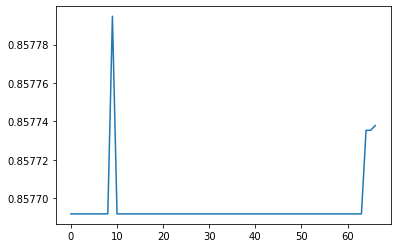

In [64]:
value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
quant_trans_uniform = QuantileTransformer(output_distribution='uniform')
model = make_pipeline(quant_trans_uniform, lgbm)
scores = []

iteration = 0
print('Done iterations: ', end='')
for x in range(147, 1, -1):
    iteration+=1
    columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, x-1, -1)]))
    columns_to_remove += ['Vintage']
    score = cross_val_score(model, X_le_psc.drop(columns=columns_to_remove), y, cv=10, scoring='roc_auc').mean()
    scores += [score]
    print(str(iteration) + ",", end='')

scores_series = pd.Series(scores)
plt.plot(scores_series.index, scores_series.values)

I'm sure I can remove 60 columns without affecting model performance, but I still need to look at the results for other scalers.

In [4]:
value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, 86, -1)]))
columns_to_remove += ['Vintage']

compare_preprocessing(lgbm, X_le_psc.drop(columns=columns_to_remove), y)

Cross validation time: 5.6952736377716064 seconds
Mean ROC_AUC score without scaler: 0.8574873160321502
Cross validation time: 12.071979999542236 seconds
Mean ROC_AUC score with scaler: 0.8577947969646201
Cross validation time: 162.0033049583435 seconds
Mean ROC_AUC score with transformer: 0.8577408859764913
Cross validation time: 218.17398762702942 seconds
Mean ROC_AUC score with scaler and transformer: 0.8575996426275662
Cross validation time: 15.900956869125366 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8576919569781671
Cross validation time: 24.017045259475708 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8578170529189757


The results are the same (even better for QuantileTransformer with normal distribution), but training is much faster (almost a 2-fold improvement for the model version with the transformer!). I'll do more precise feature selection after two more econdings (the results will be more accurate).

### 8.2 Target encoding on Policy_Sales_Channel

The second type of category encoding is supervised encoding. It uses target values to encode category. In practice, the algorithm is a bit more complex, but the main idea is to substitute categorical values by their mean target (the "Response" column). Let's encode Policy_Sales_Channel in this way and compare results for various scalers:

In [ ]:
from category_encoders import TargetEncoder

def compare_preprocessing_te(model, X, y, te_columns):
    encoder = TargetEncoder(cols=te_columns)

    scaler = StandardScaler()
    transformer = PowerTransformer()
    scaler_without_std = StandardScaler(with_std=False)
    quant_trans_uniform = QuantileTransformer(output_distribution='uniform')
    quant_trans_normal = QuantileTransformer(output_distribution='normal')

    model_te = make_pipeline(encoder, model)
    model_scaler = make_pipeline(encoder, scaler, model)
    model_transformer = make_pipeline(encoder, transformer, model)
    model_scaler_transformer = make_pipeline(encoder, scaler_without_std, transformer, model)
    model_quant_trans_uniform = make_pipeline(encoder, quant_trans_uniform, model)
    model_quant_trans_normal = make_pipeline(encoder, quant_trans_normal, model)

    cross_val_summary(model_te, X, y, message="Mean ROC_AUC score without scaler: ")
    cross_val_summary(model_scaler, X, y, message="Mean ROC_AUC score with scaler: ")
    cross_val_summary(model_transformer, X, y, message="Mean ROC_AUC score with transformer: ")
    cross_val_summary(model_scaler_transformer, X, y, message="Mean ROC_AUC score with scaler and transformer: ")
    cross_val_summary(model_quant_trans_uniform, X, y, message="Mean ROC_AUC score with QuantileTransformer (uniform distribution): ")
    cross_val_summary(model_quant_trans_normal, X, y, message="Mean ROC_AUC score with QuantileTransformer (normal distribution): ")

In [4]:
X_le_psc_te = X_le_psc.drop(columns=columns_to_remove).copy()
X_le_psc_te['Policy_Sales_Channel_te'] = X_le_psc_te['Policy_Sales_Channel']
compare_preprocessing_te(lgbm, X_le_psc_te, y, ['Policy_Sales_Channel'])

Cross validation time: 6.895636558532715 seconds
Mean ROC_AUC score without scaler: 0.8578516811768312
Cross validation time: 12.551993131637573 seconds
Mean ROC_AUC score with scaler: 0.8578067917946631
Cross validation time: 162.76739883422852 seconds
Mean ROC_AUC score with transformer: 0.8577500725688326
Cross validation time: 219.64318704605103 seconds
Mean ROC_AUC score with scaler and transformer: 0.857805818285436
Cross validation time: 17.547009229660034 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8577424395726098
Cross validation time: 24.262820720672607 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8578096972047613


Except for the QuantileTransformer with a normal distribution, all results are better. 

I checked, and the results without the original Policy_Sales_Channel column are worse.

## 9. TargetEncoding on Region_Code

Now I'll use the same method for Region_Code - with and without the non-encoded version.

First - without the original Region_Code column:

In [5]:
compare_preprocessing_te(lgbm, X_le_psc_te, y, ['Policy_Sales_Channel', 'Region_Code'])

Cross validation time: 7.385013580322266 seconds
Mean ROC_AUC score without scaler: 0.8578672559914619
Cross validation time: 12.798346519470215 seconds
Mean ROC_AUC score with scaler: 0.8580431893748506
Cross validation time: 163.73356127738953 seconds
Mean ROC_AUC score with transformer: 0.8580417526017181
Cross validation time: 218.94549584388733 seconds
Mean ROC_AUC score with scaler and transformer: 0.8580898524585432
Cross validation time: 17.591765880584717 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.858124605199893
Cross validation time: 24.033880710601807 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8579435208664062


With the original Region_Code column:

In [6]:
X_le_psc_te_rc = X_le_psc_te.copy()
X_le_psc_te_rc['Region_Code_te'] = X_le_psc_te_rc['Region_Code']

compare_preprocessing_te(lgbm, X_le_psc_te_rc, y, ['Policy_Sales_Channel', 'Region_Code'])

Cross validation time: 7.1955201625823975 seconds
Mean ROC_AUC score without scaler: 0.8582197639563397
Cross validation time: 12.822477102279663 seconds
Mean ROC_AUC score with scaler: 0.8581328309025407
Cross validation time: 163.78668522834778 seconds
Mean ROC_AUC score with transformer: 0.8583319013615907
Cross validation time: 221.69700169563293 seconds
Mean ROC_AUC score with scaler and transformer: 0.8580616992741815
Cross validation time: 18.147982358932495 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8580370579413217
Cross validation time: 24.764060258865356 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8581242602095361


Some of these results are very similar, but I need to choose a single version for the rest of the article (continuing calculations for all types of scalers would be very long). I chose PowerTransformer with an additional, original column because it provided the highest result.

The execution time of PowerTransformer is quite long, so if you don't have enough time or hardware resources, I recommend a standard scaler for you. It's more than 10 times faster and still obtains a great score.

# 10. Feature selection

The present model still has an alot of useless features. Most likely, removing many of them could be done more quickly and with better results. There are some good automated tools for it (like Recursive Feature Elimination), but I ran into issues with:  
a) lower final result  
b) very slow feature selection algorithm execution

I made the decision to use my own algorithm. Each time, I'll see if I can get the same or better results by removing one feature (from the list of all features apart from "fixed columns"). I'll keep repeating the algorithm till it doesn't eliminate any feature in the cycle.

The SequentialFeatureSelector could achieve a slightly higher score, but with ***much*** longer execution time. 

In [3]:
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
transformer = PowerTransformer()
model = make_pipeline(encoder, transformer, lgbm)

def feature_selection(X, y):
    full_cycle_iter = 0
    cycle_score = None
    fixed_columns = ['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Annual_Premium', 'Policy_Sales_Channel', 'Policy_Sales_Channel_te', 'Region_Code_te']
    columns_to_remove = []
    columns_to_remove_len_before_cycle = 0

    while True:
        full_cycle_iter += 1
        columns_to_remove_len_before_cycle = len(columns_to_remove)
        print("Starting full cycle number " + str(full_cycle_iter))
        selection_columns = [col for col in X.drop(columns=columns_to_remove).columns.values if col not in fixed_columns]
        base_score = cross_val_score(model, X.drop(columns=columns_to_remove), y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
        if cycle_score is None:
            cycle_score = base_score
        print("Calculated base score: " + str(base_score))
        counter=0
        print("Finished iterations: ", end='')
        for column in selection_columns:
            score_without_column = cross_val_score(model, X.drop(columns=columns_to_remove+[column]), y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
            counter += 1
            print(str(counter) + ",", end='')
            if score_without_column >= base_score:
                base_score = score_without_column
                columns_to_remove += [column]
        if columns_to_remove_len_before_cycle == len(columns_to_remove):
            print()
            print("No columns added in this cycle")
            break
        else:
            cycle_score = base_score

        pd.Series(columns_to_remove).to_csv('results/test_columns_to_remov' + str(full_cycle_iter) + '.csv')
        print()
        print("Score after " + str(full_cycle_iter) + " cycle: " + str(base_score))
        print(str(len(columns_to_remove)) + " columns was removed")
    
# feature_selection(X_le_psc_te_rc, y)

Calculations consume a lot of time and resources, so I executed them outside of this notebook. You can run them by uncommenting last line of the previous cell.

Here I'll only load results:

In [9]:
selected_to_remove = pd.read_csv('results/columns_to_remov4.csv', index_col=0)["0"]
print("Number of columns selected to remove: " + str(len(selected_to_remove)))

Number of columns selected to remove: 52


The algorithm removed more than half of columns! Let's check score and time improvement:

In [8]:
selected_to_remove = pd.read_csv('results/columns_to_remov4.csv', index_col=0)["0"]
X_final.drop(columns=selected_to_remove)
cross_val_summary(model, X_final.drop(columns=selected_to_remove), y)

Cross validation time: 73.4052996635437 seconds
Mean score: 0.8583790502627309


Score improvement is not so big (about 0.00004 ROC_AUC point), but single training execution is more than two times faster.

## 12. Region_Code OHE and feature selection

First, let's take a deeper look at Region_Code distribution:

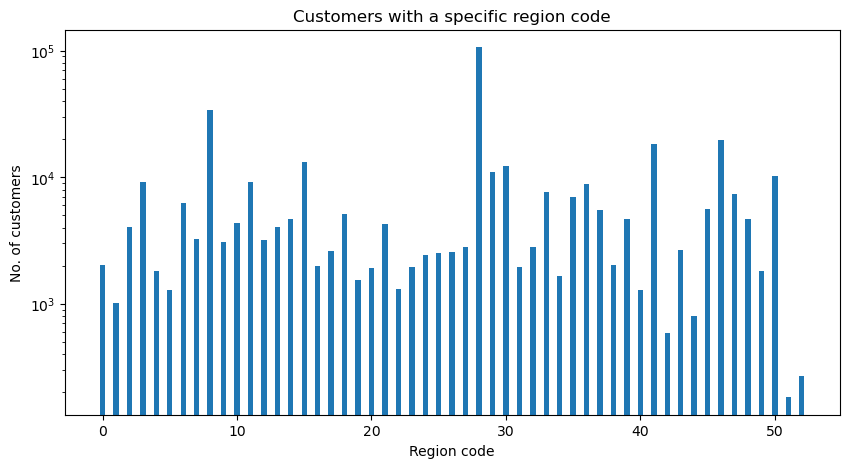

In [15]:
data = X_le.Region_Code.value_counts()
region_code = list(data.index.tolist())
customers = list(data.values.tolist())

fig = plt.figure(figsize = (10, 5))
plt.bar(region_code, customers,
        width = 0.4, log=True)
 
plt.xlabel("Region code")
plt.ylabel("No. of customers")
plt.title("Customers with a specific region code")
plt.show()

There are no really small categories, but still - the smallest one has 183 samples and the biggest one has over 100k samples. Please note that this bar has a logarithmic scale.

Next, I'll calculate score with all of the Region_Code categories transformed by One Hot Encoder:

In [15]:
X_rc_ohe = X_final.drop(columns=selected_to_remove)
rc_ohe = pd.get_dummies(X_rc_ohe["Region_Code"], prefix="Region_Code")
X_rc_ohe = pd.concat([X_rc_ohe, rc_ohe], axis=1)

encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
transformer = PowerTransformer()
model = make_pipeline(encoder, transformer, lgbm)

cross_val_score(model, X_rc_ohe, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8581446785145823

The result with all of the Region_Code columns after One Hot Encoding is lower than without them, so I'll try to add only some of them. The algorithm will be fairly similar to that from the "feature selection" paragraph, I'll aim to add a column during each iteration rather than eliminating it (in this case, a backward selection might not even obtain a result before the Region_Code OHE):

In [ ]:
# TODO: D.R.Y. - look at "feature selection" paragraph
def forward_selection(X, path):
    encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
    transformer = PowerTransformer()
    model = make_pipeline(encoder, transformer, lgbm)

    full_cycle_iter = 0
    cycle_score = None
    fixed_columns = [x for x in X if x not in rc_ohe.columns]
    columns_to_add = []
    columns_to_add_len_before_cycle = 0

    while True:
        full_cycle_iter += 1
        columns_to_add_len_before_cycle = len(columns_to_add)
        print("Starting full cycle number " + str(full_cycle_iter))
        selection_columns = [col for col in rc_ohe.columns if col not in fixed_columns and col not in columns_to_add]
        print("Number of iters in this cycle: " + str(len(selection_columns)))
        base_score = cross_val_score(model, X[fixed_columns + columns_to_add], y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
        if cycle_score is None:
            cycle_score = base_score
        print("Calculated base score: " + str(base_score))
        counter=0
        print("Finished iterations: ", end='')
        for column in selection_columns:
            score_with_column = cross_val_score(model, X[fixed_columns + columns_to_add + [column]], y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
            counter += 1
            print(str(counter) + ",", end='')
            if score_with_column >= base_score:
                base_score = score_with_column
                columns_to_add += [column]

        if columns_to_add_len_before_cycle == len(columns_to_add):
            print()
            print("No columns added in this cycle")
            break
        else:
            cycle_score = base_score

        pd.Series(columns_to_add).to_csv(path + str(full_cycle_iter) + '.csv')
        print()
        print("Score after " + str(full_cycle_iter) + " cycle: " + str(base_score))
        print(str(len(columns_to_add)) + " columns was added")

# forward_selection(X_rc_ohe, 'results/columns_to_add_rc')

Because the calculations are lengthy, I commented out the line with function execution, and I'll just load the results from file here.

With four additional columns, the model gave a slightly higher result.

Outside of this notebook, I used backward selection to choose features, but the execution time was very long, and the final model had lower performance.

# Partial PowerTransformer

In [8]:
from sklearn.compose import ColumnTransformer

fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
# TODO: load columns from file
columns_to_add = ["Region_Code_0.0", "Region_Code_1.0", "Region_Code_38.0", "Region_Code_52.0"]

encoder = TargetEncoder(cols=['Region_Code', 'Policy_Sales_Channel'])

full_cycle_iter = 0
cycle_score = None
columns_wo_tran_len_before_cycle = 0
columns_without_transformer = []
X_reduce_te = X_rc_ohe[fixed_columns + columns_to_add]

while True:
    all_columns = [x for x in X_reduce_te.columns.values if x not in columns_without_transformer]
    full_cycle_iter += 1
    print("Starting full cycle number " + str(full_cycle_iter))
    print("All columns number: " + str(len(all_columns)))
    columns_wo_tran_len_before_cycle = len(columns_without_transformer)
    transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])
    model = make_pipeline(encoder, transformer, lgbm)
    base_score = cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
    print("Base score: " + str(base_score))
    if cycle_score is None:
        cycle_score = base_score
    counter = 0
    print("Iterations finished: ", end='')
    for column in all_columns:
        columns_for_transformer = [x for x in all_columns if x not in columns_without_transformer + [column]]
        transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), columns_for_transformer)])
        model = make_pipeline(encoder, transformer, lgbm)

        score = cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
        counter += 1
        print(str(counter), end='')
    
        if score >= base_score:
            base_score = score
            print("Score for transformer without " + column + " column: " + str(score))
            columns_without_transformer += [column]
    
    if columns_wo_tran_len_before_cycle == len(columns_without_transformer):
        print("No columns added in this cycle")
        break
    else:
        cycle_score = base_score

    pd.Series(columns_without_transformer).to_csv('results/columns_without_transformer' + str(full_cycle_iter) + '.csv')
    print("Score after " + str(full_cycle_iter) + " cycle: " + str(base_score))
    print(str(len(columns_without_transformer)) + " columns was removed")
    print()

Starting full cycle number 1
All columns number: 50
Base score: 0.8583829382706879
Iterations finished: 123456789101112131415161718192021222324252627282930

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

3132

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

33

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

34

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

35

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

36

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

3738

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

394041

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

42

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

434445

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

4647Score for transformer without Region_Code_0.0 column: 0.8583829382706879
4849Score for transformer without Region_Code_38.0 column: 0.8583829382706879
50Score for transformer without Region_Code_52.0 column: 0.8583829382706879
Score after 1 cycle: 0.8583829382706879
3 columns was removed

Starting full cycle number 2
All columns number: 47
Base score: 0.8583829382706879
Iterations finished: 12345678910111213

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

1415

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

161718

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

19202122

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

2324

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

25

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

26

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

2728293031

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

32

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

333435363738394041424344454647No columns added in this cycle


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

We have the same score, but the model is slightly faster without transforming columns "Region_Code_0.0", "Region_Code_38.0" and "Region_Code_52.0". It's not a big improvement, but I'll use it for faster tuning.

## TargetEncoding on Vehicle_Age

In [7]:
X_vage_te = X_reduce_te.copy()

transformer_columns = [x for x in X_vage_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]

encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code', 'Vehicle_Age'])
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), transformer_columns)])

model = make_pipeline(encoder, transformer, lgbm)
cross_val_score(model, X_vage_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8580166335152419

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

It doesn't improve the result.

## Oversampling/SMOTE

In [10]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
model = Pipeline([('over', oversample), ('enc', encoder), ('trans', transformer), ('lgbm', lgbm)])

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8581684909994174

In [11]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
model = Pipeline([('enc', encoder), ('over', oversample), ('trans', transformer), ('lgbm', lgbm)])

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8581055667809746

In [12]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
model = Pipeline([('enc', encoder), ('trans', transformer), ('over', oversample), ('lgbm', lgbm)])

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.858204569951902

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

In [7]:
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE

smote = SMOTE()
model = Pipeline([('smt', smote), ('enc', encoder), ('trans', transformer), ('lgbm', lgbm)])

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8420298085837888

In [8]:
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE

smote = SMOTE()
model = Pipeline([('enc', encoder), ('smt', smote), ('trans', transformer), ('lgbm', lgbm)])

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.840975800838976

In [9]:
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE

smote = SMOTE()
model = Pipeline([('enc', encoder), ('trans', transformer), ('smt', smote), ('lgbm', lgbm)])

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8520831275035989

It didn't improve the result. I tried to use the sampler as another step in the pipeline, but it returned an even worse score.

## Model tuning

In [1]:
# TODO: remove cell
from articlecommon import *
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
lgbm = LGBMClassifier(random_state=42, verbose=-1)
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")
X_le_psc = pd.concat([X_le, psc_ohe], axis=1)



psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()
counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)

value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, 86, -1)]))
columns_to_remove += ['Vintage']

from category_encoders import TargetEncoder
X_le_psc_te = X_le_psc.drop(columns=columns_to_remove).copy()
X_le_psc_te['Policy_Sales_Channel_te'] = X_le_psc_te['Policy_Sales_Channel']

X_le_psc_te_rc = X_le_psc_te.copy()
X_le_psc_te_rc['Region_Code_te'] = X_le_psc_te_rc['Region_Code']
selected_to_remove = pd.read_csv('results/columns_to_remov4.csv', index_col=0)["0"]

X_final = X_le_psc_te_rc
X_rc_ohe = X_final.drop(columns=selected_to_remove)
rc_ohe = pd.get_dummies(X_rc_ohe["Region_Code"], prefix="Region_Code")
X_rc_ohe = pd.concat([X_rc_ohe, rc_ohe], axis=1)

fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
columns_to_add = ["Region_Code_0.0", "Region_Code_1.0", "Region_Code_38.0", "Region_Code_52.0"]

encoder = TargetEncoder(cols=['Region_Code', 'Policy_Sales_Channel'])
X_reduce_te = X_rc_ohe[fixed_columns + columns_to_add]

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]

transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
model = make_pipeline(encoder, transformer, lgbm)

# cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

In [3]:
import optuna
np.seterr(all="ignore")

trials_number = 100

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])


def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1.0)
    max_depth = -1
    depth_limit = trial.suggest_categorical("depth_limit", [True, False])
    if depth_limit is True:
        max_depth = trial.suggest_int("max_depth", 2, 9)
    num_leaves_pow = trial.suggest_int("num_leaves_pow", 2, 9)
    num_leaves = 2 ** num_leaves_pow
    n_estimators = trial.suggest_int('n_estimators', 50, 2500)
    subsample = trial.suggest_uniform('subsample', 0.3, 1.0)
    class_weight = trial.suggest_categorical("class_weight", [None, 'balanced'])
    te_smoothing = trial.suggest_loguniform("te_smoothing", 0.05, 5.0)
    reg_alpha = trial.suggest_uniform("reg_alpha", 0.0, 1.0)
    reg_lambda = trial.suggest_uniform("reg_lambda", 0.0, 1.0)

    
    lgbm = LGBMClassifier(random_state=42, verbose=-1, learning_rate=learning_rate, max_depth=max_depth, num_leaves=num_leaves, n_estimators=n_estimators, subsample=subsample, class_weight=class_weight)
    encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
    model = make_pipeline(encoder, transformer, lgbm)

    score = cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
    if trial.number == 0:
        print("Finished trials: 1", end="")
    else:
        print(", " + str(trial.number+1), end="")
    return score

study = optuna.create_study(direction="maximize")

study.enqueue_trial({
        "learning_rate": 0.005017264032393435,
        "depth_limit": False,
        "max_depth": 5,
        "num_leaves_pow": 6,
        "n_estimators": 1469,
        "subsample": 0.47151419221112034,
        "class_weight": None,
        "te_smoothing": 2.9510219777055813,
        "reg_alpha": 0.0,
        "reg_lambda": 0.0
    })

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=trials_number)

print("\nBest trial:")
trial = study.best_trial

print("  ROC AUC: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Finished trials: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

, 31, 32, 33

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

, 34

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

, 35

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 36

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 37, 38

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 39

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

, 40

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 41, 42, 43, 44, 45

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

, 65, 66

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

, 67, 68, 69, 70

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

, 71, 72

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 73

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 74

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 75, 76

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

, 77, 78

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

, 79, 80, 81, 82, 83, 84, 85

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

, 99, 100
Best trial:
  ROC AUC: 0.8588986626649424
  Params: 
    learning_rate: 0.010259408143780216
    depth_limit: True
    max_depth: 5
    num_leaves_pow: 9
    n_estimators: 2371
    subsample: 0.6951379234882272
    class_weight: None
    te_smoothing: 0.6741836510673999
    reg_alpha: 0.163111686021624
    reg_lambda: 0.2639575808284711


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

In [2]:
all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])

learning_rate = 0.010259408143780216
max_depth = 5
num_leaves_pow = 9
num_leaves = 2 ** num_leaves_pow
n_estimators = 2371
subsample = 0.6951379234882272
class_weight = None
te_smoothing = 0.6741836510673999
reg_alpha = 0.163111686021624
reg_lambda = 0.2639575808284711

    
lgbm = LGBMClassifier(random_state=42, verbose=-1, learning_rate=learning_rate, max_depth=max_depth, num_leaves=num_leaves, n_estimators=n_estimators, subsample=subsample, class_weight=class_weight)
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
model = make_pipeline(encoder, transformer, lgbm)

score = cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

The model provided a noticeable boost. It achives ***0.8588986626649424*** score with a lower learning rate \~0.01 (default 0.1). Much higher estimators number 2371 (default 100) extend execution time. Optuna decided to use some techniques to curb the overtraining problem: a lower subsample ratio of the training instance (\~0.7 instead of 1.0), L1 and L2 regularization, and a fixed maximum tree depth.

## XGB model
eXtreme Gradient Boosting is a more powerful but slower algorithm. LightGBM can sometimes obtain higher performance, but usually XGBoost has a slightly better result and significantly slower execution time. A detailed comparison of these algorithms would be too long for this article, so I encourage you to watch [this video](https://www.youtube.com/watch?v=5CWwwtEM2TA) if you're interested in the topic.

In [3]:
# TODO: remove cell
from articlecommon import *
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
lgbm = LGBMClassifier(random_state=42, verbose=-1)
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")
X_le_psc = pd.concat([X_le, psc_ohe], axis=1)



psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()

counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)

value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, 86, -1)]))
columns_to_remove += ['Vintage']

from category_encoders import TargetEncoder
X_le_psc_te = X_le_psc.drop(columns=columns_to_remove).copy()
X_le_psc_te['Policy_Sales_Channel_te'] = X_le_psc_te['Policy_Sales_Channel']

X_le_psc_te_rc = X_le_psc_te.copy()
X_le_psc_te_rc['Region_Code_te'] = X_le_psc_te_rc['Region_Code']
selected_to_remove = pd.read_csv('results/columns_to_remov4.csv', index_col=0)["0"]

X_final = X_le_psc_te_rc
X_rc_ohe = X_final.drop(columns=selected_to_remove)
rc_ohe = pd.get_dummies(X_rc_ohe["Region_Code"], prefix="Region_Code")
X_rc_ohe = pd.concat([X_rc_ohe, rc_ohe], axis=1)

fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
columns_to_add = ["Region_Code_0.0", "Region_Code_1.0", "Region_Code_38.0", "Region_Code_52.0"]

encoder = TargetEncoder(cols=['Region_Code', 'Policy_Sales_Channel'])
# X_reduce_te = X_rc_ohe[fixed_columns + columns_to_add]
X_reduce_te = X_rc_ohe.loc[:, fixed_columns + columns_to_add]

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]



In [3]:
import optuna
np.seterr(all="ignore")

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])


def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1.0)
    max_depth = trial.suggest_int("max_depth", 2, 10)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    subsample = trial.suggest_uniform('subsample', 0.4, 1.0)
    te_smoothing = trial.suggest_loguniform("te_smoothing", 0.05, 10.0)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 7)
    gamma = trial.suggest_uniform("gamma", 0.0, 1.0)
    colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.3, 1.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-3, 1e2)

    
    xgb = XGBClassifier(random_state=42, eval_metric="logloss", learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample, min_child_weight=min_child_weight, gamma=gamma, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha)
    encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
    model = make_pipeline(encoder, transformer, xgb)

    score = cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
    print("  ROC AUC: {}".format(score))

    print("  Params for trial " + str(trial.number) + ": ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    return score

In [3]:
trials_number = 70

study_name = 'xgb-study'
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, direction="maximize", storage=storage_name, load_if_exists=True,)

study.enqueue_trial({
        "learning_rate": 0.05014352877833517,
        "max_depth": 7,
        "min_child_weight": 5,
        "n_estimators": 234,
        "subsample": 0.9009423215546716,
        "class_weight": None,
        "te_smoothing": 0.20145207364872467,
        "gamma": 0.2491618356357863,
        "colsample_bytree": 0.631803937308591,
        "reg_alpha": 0.025408324931767336
    })

optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(objective, n_trials=trials_number)

[I 2022-12-13 13:28:49,624] Using an existing study with name 'xgb-study' instead of creating a new one.


As you can see, I have commented the last line. Tuning takes a lot of time and resources. I have finished it outside of this notebook, and here I'll just load the final parameters. It is possible, because Optuna can save results in a sqlite (simple relational database) file. This trick allows you to train the model piece by piece. It is not necessary to calculate all the trials in a single tuning execution. Very useful when you can't afford to use one workstation for too long.

In [4]:
print("\nBest trial:")
trial = study.best_trial

print("  ROC AUC: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Best trial:
  ROC AUC: 0.8590739770495592
  Params: 
    colsample_bytree: 0.759012193204171
    gamma: 0.20241066830358567
    learning_rate: 0.021291366221284337
    max_depth: 8
    min_child_weight: 5
    n_estimators: 476
    reg_alpha: 0.010982331080557824
    subsample: 0.8706268352745364
    te_smoothing: 0.35648520716557985


The XGB's execution time is much higher, but its score is improved. It is probably possible to achieve a slightly higher result, but only after extensive training. The number of estimators is not so large, and the learning rate is about two times higher than in the LGBM version.

For these parameters training time is several tens of percent faster than final LGBM classifier. The main reasons are probably XGBs lower estimators number and maximum tree depth.

In [4]:
learning_rate = 0.021291366221284337
max_depth = 8
n_estimators = 476
subsample = 0.8706268352745364
te_smoothing = 0.35648520716557985
min_child_weight = 5
gamma = 0.20241066830358567
colsample_bytree = 0.759012193204171
reg_alpha = 0.010982331080557824


xgb = XGBClassifier(random_state=42, eval_metric="logloss", learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample, min_child_weight=min_child_weight, gamma=gamma, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha)
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
model = make_pipeline(encoder, transformer, xgb)
model.fit(X_reduce_te, y)

Pipeline(steps=[('targetencoder',
                 TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'],
                               smoothing=0.35648520716557985)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pwrtrans',
                                                  PowerTransformer(),
                                                  ['Gender', 'Age',
                                                   'Driving_License',
                                                   'Region_Code',
                                                   'Previously_Insured',
                                                   'Vehicle_Age',
                                                   'Vehicle_Damage',
                                                   'Annual_Premium',
                                                   'Policy_Sales_Channel',
                                                   'Po...
                               interaction_constraints='',
                               learning_rate=0.021291366221284337,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=5, missing=nan,
                               monotone_constraints='()', n_estimators=476,
                               n_jobs=12, num_parallel_tree=1, random_state=42,
                               reg_alpha=0.010982331080557824, reg_lambda=1,
                               scale_pos_weight=1, subsample=0.8706268352745364,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [14]:
xgb.save_model("xgb-model.json")

## Model explainability

After some fancy tricks, the model produces a reasonable result. But what does he really do? Does he consider the features we highlighted in our initial analysis to be just as important?

Because the final model has more features, let's calculate mutual information for all of them again and plot the 15 with the highest score:

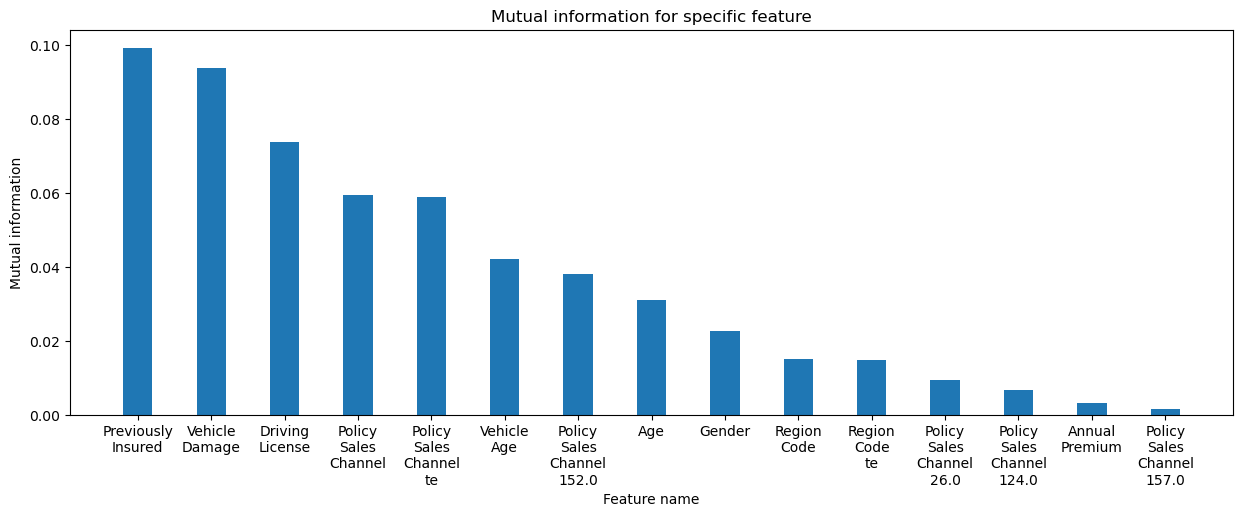

In [16]:
mi = mutual_info_classif(X_reduce_te, y, random_state=42)

data = pd.Series(mi, name="MI Scores", index=X_reduce_te.columns).sort_values(ascending=False)
region_code = list(map(underscore_to_space, data.index.tolist()))
customers = list(data.values.tolist())

fig = plt.figure(figsize = (15, 5))
plt.bar(region_code[:15], customers[:15],
        width = 0.4)
 
plt.xlabel("Feature name")
plt.ylabel("Mutual information")
plt.title("Mutual information for specific feature")
plt.show()

### Feature importances

Trained model gives us some statistics about features. I will print them using "plot_importance" function:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

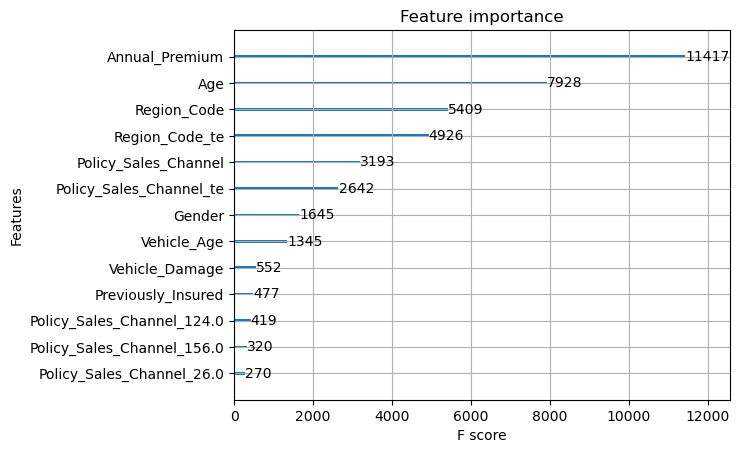

In [7]:
from xgboost import plot_importance
import xgboost
xgb_loaded = xgboost.Booster()
xgb_loaded.load_model("xgb-model.json")
xgb_loaded.feature_names = X_reduce_te.columns.values.tolist()
plot_importance(xgb_loaded, height=0.1, max_num_features=13)

The conclusions are not identical, but we can see similarities. In three most important Policy_Sales_Channel One Hot Encoding columns there are number 124 and 26. Original, non-transformed columns have very high score, but their order is different.

## Graphviz

In [4]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(xgb_loaded, out_file=None, feature_names=X_reduce_te.columns)
graphviz.Source(tree_graph)

TypeError: <xgboost.core.Booster object at 0x7f39ca4a3bb0> is not an estimator instance.

In [3]:
learning_rate = 0.021291366221284337
max_depth = 8
n_estimators = 476
subsample = 0.8706268352745364
te_smoothing = 0.35648520716557985
min_child_weight = 5
gamma = 0.20241066830358567
colsample_bytree = 0.759012193204171
reg_alpha = 0.010982331080557824


xgb = XGBClassifier(random_state=42, eval_metric="logloss", learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample, min_child_weight=min_child_weight, gamma=gamma, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha)
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
model = make_pipeline(encoder, transformer, xgb)
model.fit(X_reduce_te, y)

Pipeline(steps=[('targetencoder',
                 TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'],
                               smoothing=0.35648520716557985)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pwrtrans',
                                                  PowerTransformer(),
                                                  ['Gender', 'Age',
                                                   'Driving_License',
                                                   'Region_Code',
                                                   'Previously_Insured',
                                                   'Vehicle_Age',
                                                   'Vehicle_Damage',
                                                   'Annual_Premium',
                                                   'Policy_Sales_Channel',
                                                   'Po...
                               interaction_constraints='',
                               learning_rate=0.021291366221284337,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=5, missing=nan,
                               monotone_constraints='()', n_estimators=476,
                               n_jobs=12, num_parallel_tree=1, random_state=42,
                               reg_alpha=0.010982331080557824, reg_lambda=1,
                               scale_pos_weight=1, subsample=0.8706268352745364,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [33]:
from sklearn import tree
import graphviz
from xgboost import plot_tree

# tree_graph = tree.export_graphviz(xgb, out_file=None)
# graphviz.Source(tree_graph)
fig, ax = plt.subplots(figsize=(1, 1))
plot_tree(xgb, num_trees=1, ax=ax)
plt.show()

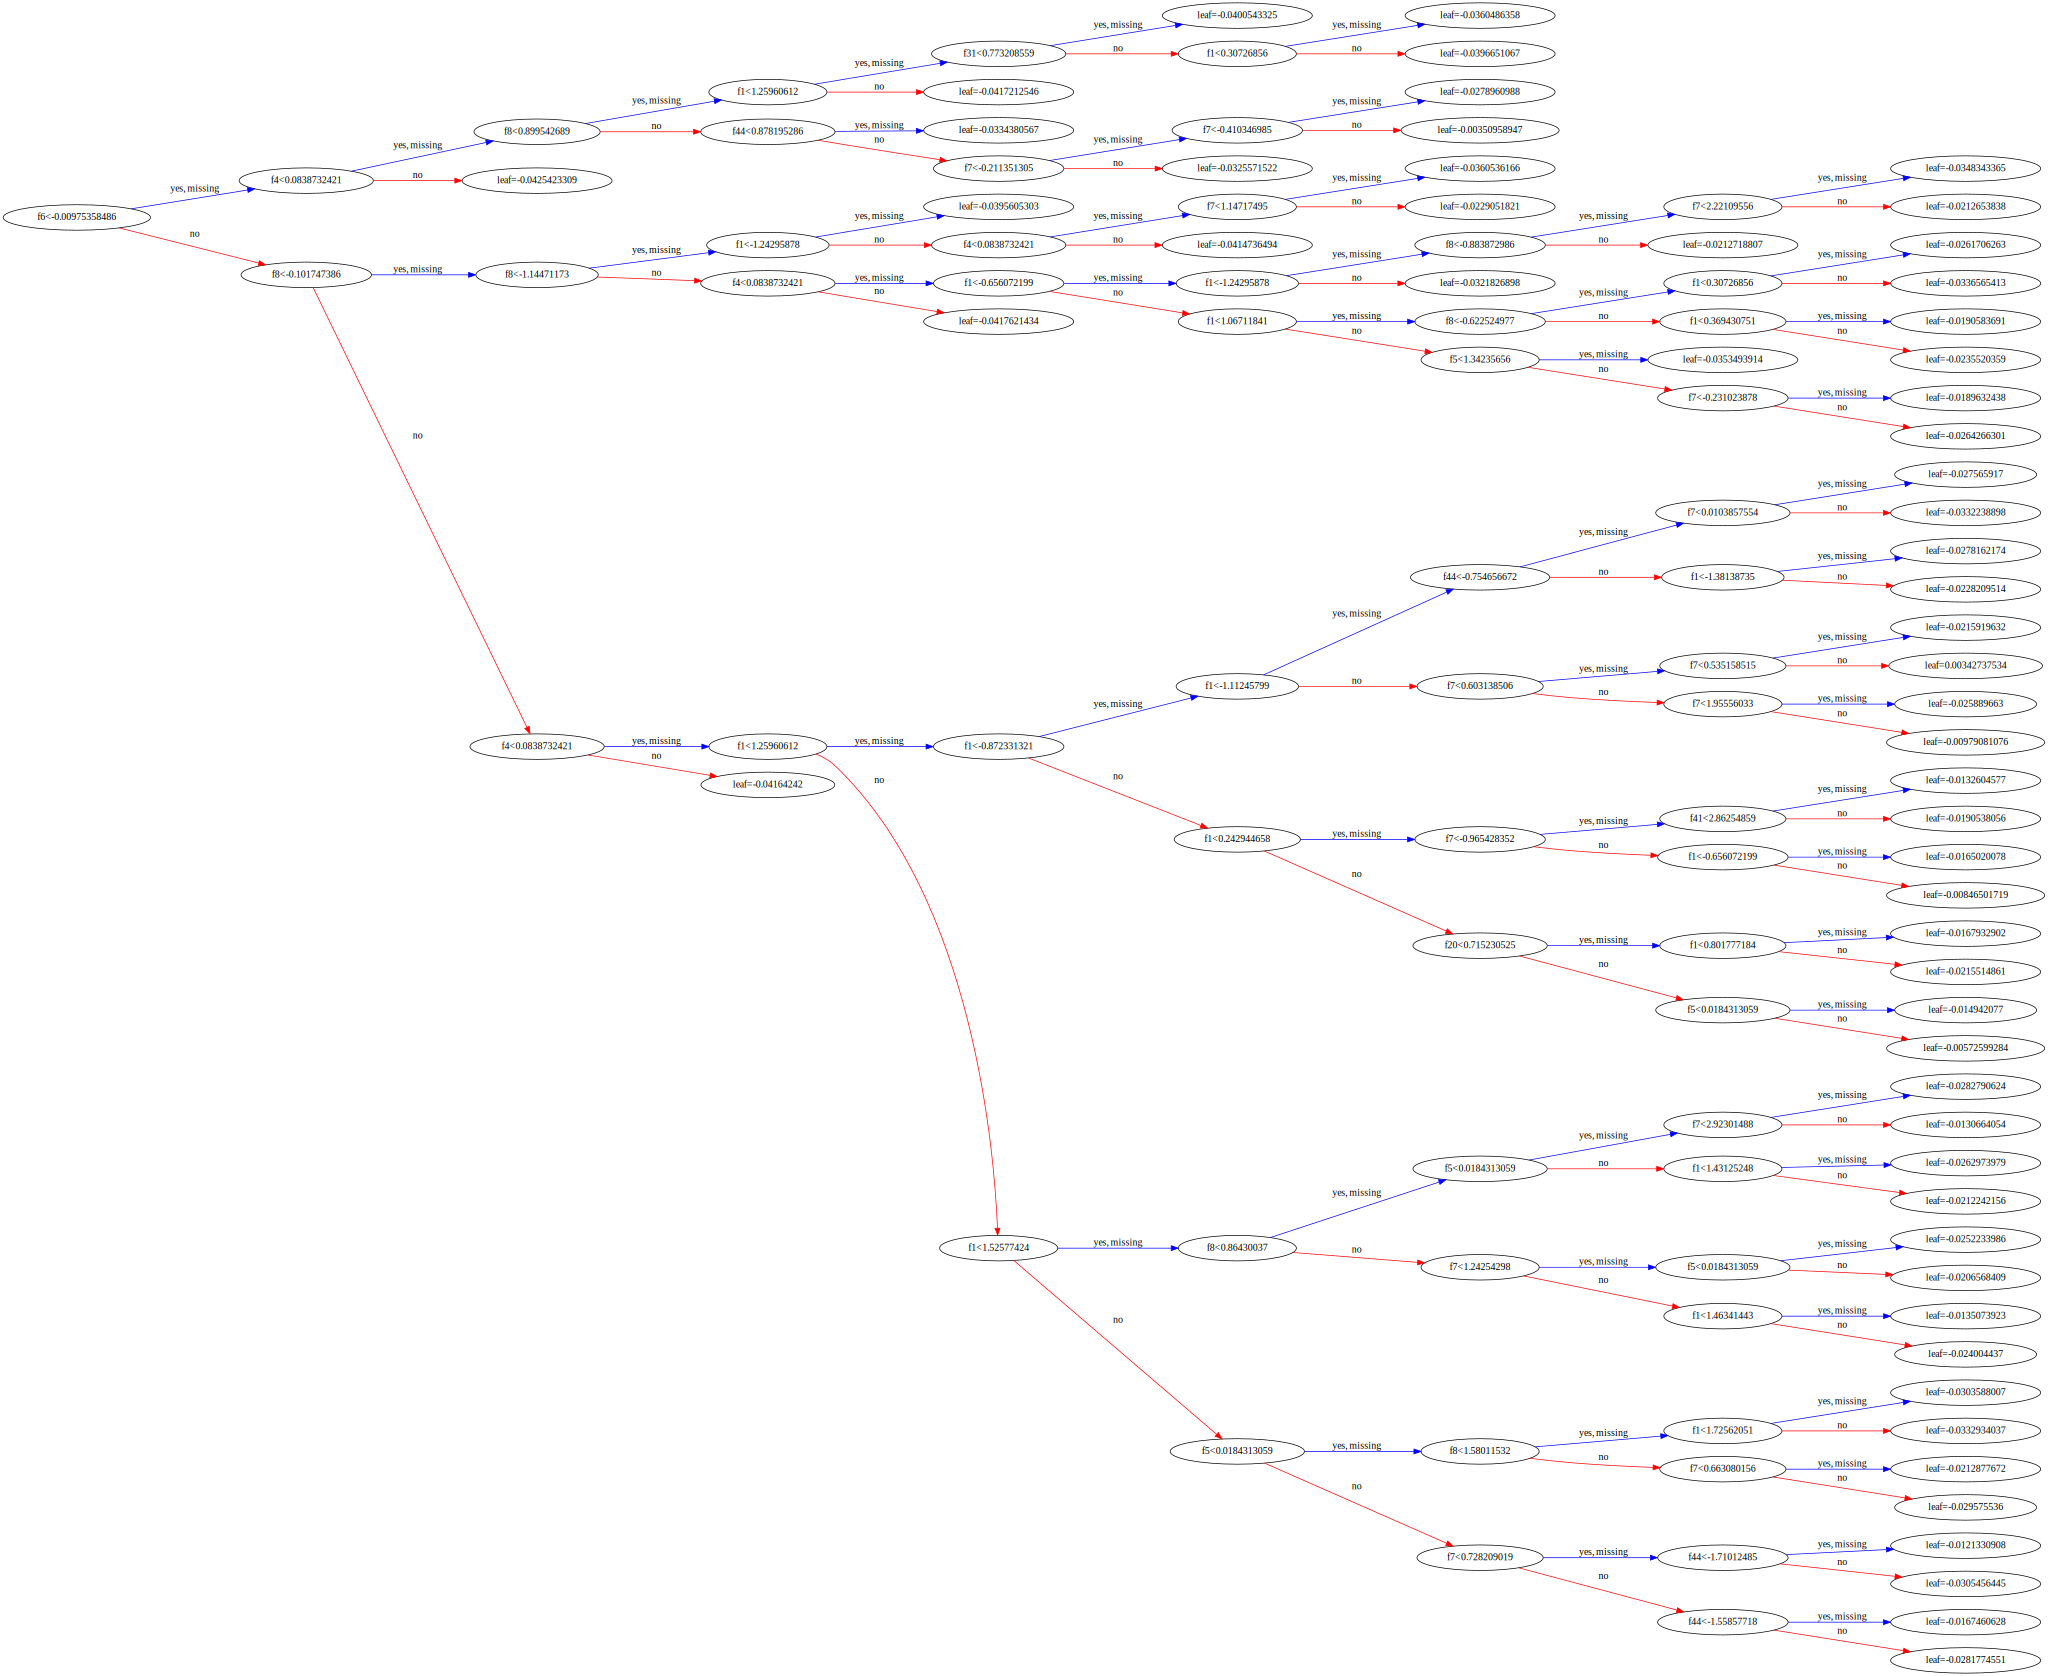

In [16]:
from sklearn import tree
import graphviz
from xgboost import to_graphviz

# tree_graph = tree.export_graphviz(xgb, out_file=None)
# graphviz.Source(tree_graph)

to_graphviz(xgb, num_trees=0, rankdir='LR')
# plt.show()

<AxesSubplot:>

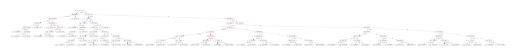

In [38]:
import xgboost
xgboost.plot_tree(booster = xgb, n_first_tree = 100)

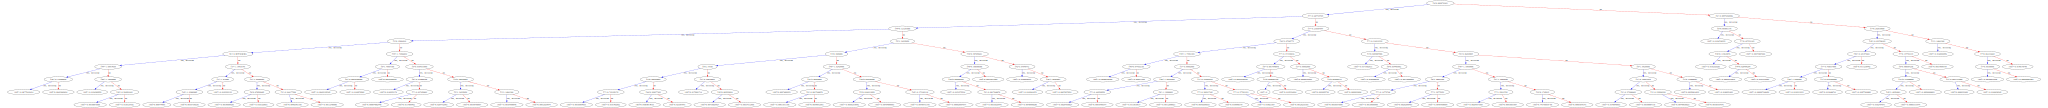

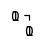

In [28]:
fig, ax = plt.subplots(figsize=(0.001, 0.001))
to_graphviz(xgb, num_trees=240, ax=ax)

### Permutation importance

In [18]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=42, cv='prefit').fit(X_reduce_te, y)
eli5.show_weights(perm, feature_names = X_reduce_te.columns.values)

Weight,Feature
0.0048 ± 0.0002,Annual_Premium
0.0036 ± 0.0003,Vehicle_Age
0.0007 ± 0.0001,Policy_Sales_Channel_152.0
0.0006 ± 0.0003,Region_Code
0.0005 ± 0.0004,Region_Code_te
0.0002 ± 0.0007,Age
0 ± 0.0000,Policy_Sales_Channel_15.0
0 ± 0.0000,Policy_Sales_Channel_30.0
0 ± 0.0000,Policy_Sales_Channel_29.0
0 ± 0.0000,Policy_Sales_Channel_25.0


Previously_Insured      0.079515
Vehicle_Damage          0.079027
Annual_Premium          0.068894
Policy_Sales_Channel    0.059944
Age                     0.030097
Vehicle_Age             0.026214
Region_Code             0.009445
Gender                  0.001388
Vintage                 0.000342
Driving_License         0.000064

### pdpbox

In [18]:
# TODO: remove
all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])

learning_rate = 0.021291366221284337
max_depth = 8
n_estimators = 476
subsample = 0.8706268352745364
te_smoothing = 0.35648520716557985
min_child_weight = 5
gamma = 0.20241066830358567
colsample_bytree = 0.759012193204171
reg_alpha = 0.010982331080557824


xgb = XGBClassifier(random_state=42, eval_metric="logloss", learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample, min_child_weight=min_child_weight, gamma=gamma, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha)
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
model = make_pipeline(encoder, transformer, xgb)
model.fit(X_reduce_te, y)

Pipeline(steps=[('targetencoder',
                 TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'],
                               smoothing=0.35648520716557985)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pwrtrans',
                                                  PowerTransformer(),
                                                  ['Gender', 'Age',
                                                   'Driving_License',
                                                   'Region_Code',
                                                   'Previously_Insured',
                                                   'Vehicle_Age',
                                                   'Vehicle_Damage',
                                                   'Annual_Premium',
                                                   'Policy_Sales_Channel',
                                                   'Po...
                               interaction_constraints='',
                               learning_rate=0.021291366221284337,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=5, missing=nan,
                               monotone_constraints='()', n_estimators=476,
                               n_jobs=12, num_parallel_tree=1, random_state=42,
                               reg_alpha=0.010982331080557824, reg_lambda=1,
                               scale_pos_weight=1, subsample=0.8706268352745364,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


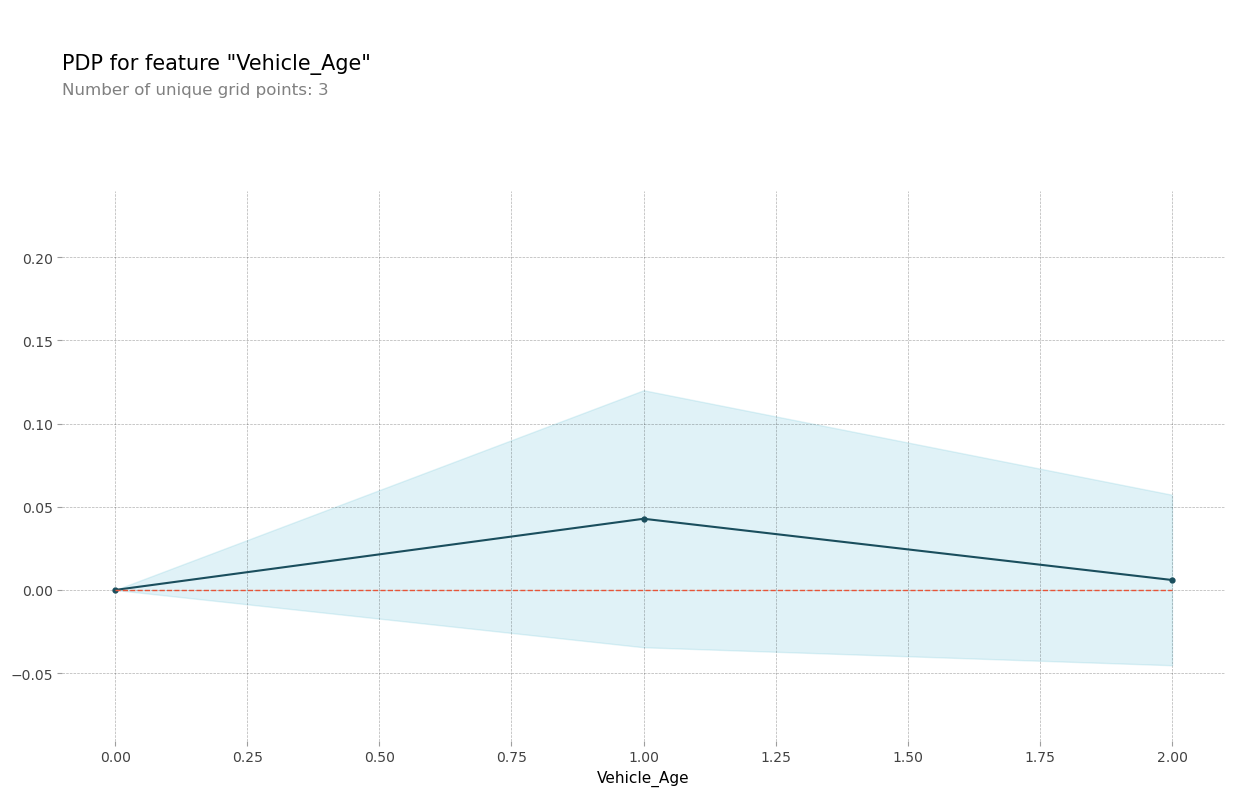

In [23]:
from pdpbox import pdp, get_dataset, info_plots

feature_names = X_reduce_te.columns.values.tolist()
selected_feature = "Vehicle_Age"
pdp_isolated = pdp.pdp_isolate(model=model, dataset=X_reduce_te, model_features=feature_names, feature=selected_feature)
pdp.pdp_plot(pdp_isolated, selected_feature)
plt.show()

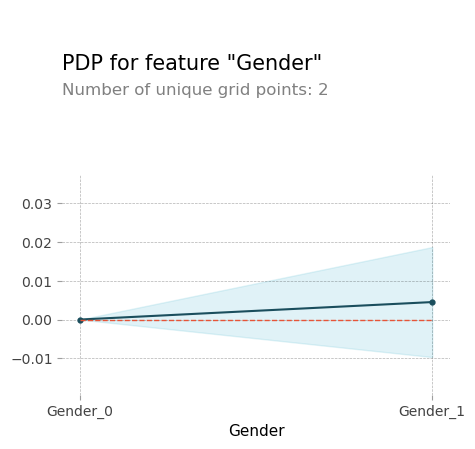

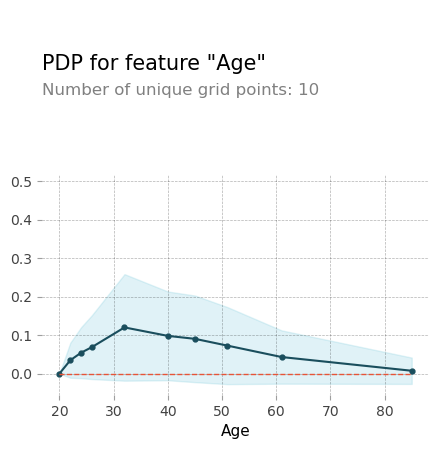

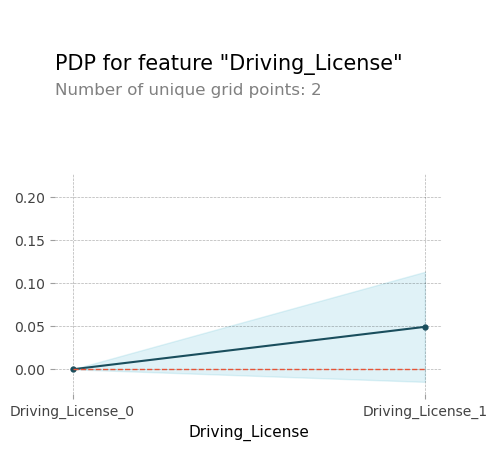

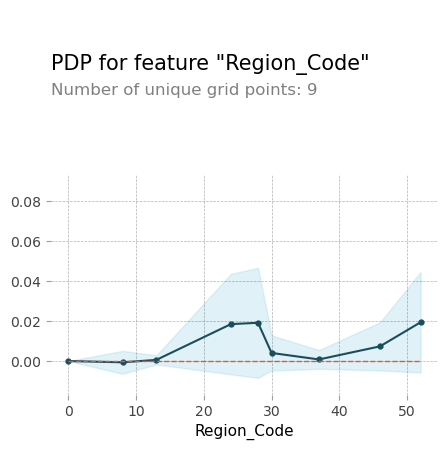

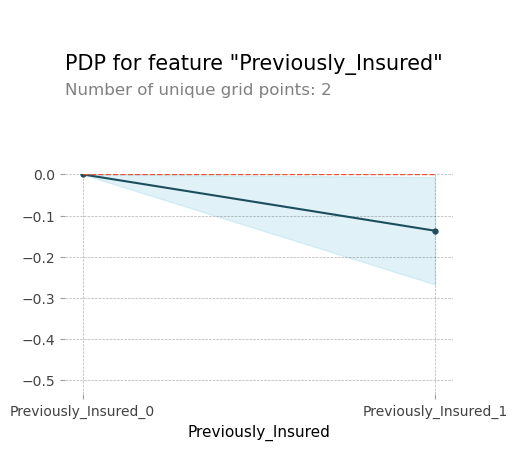

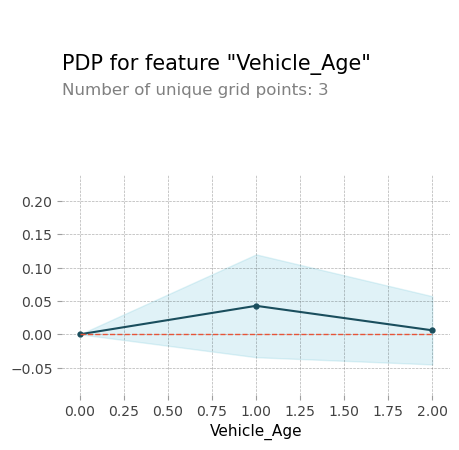

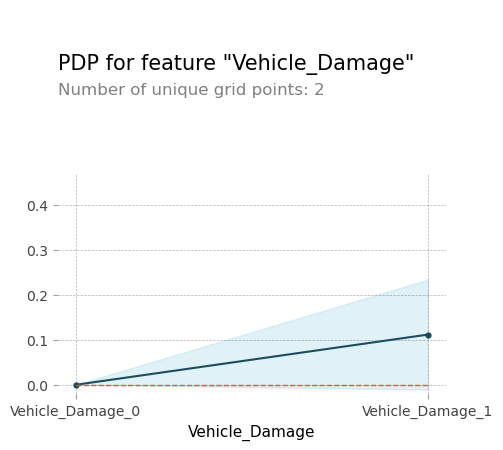

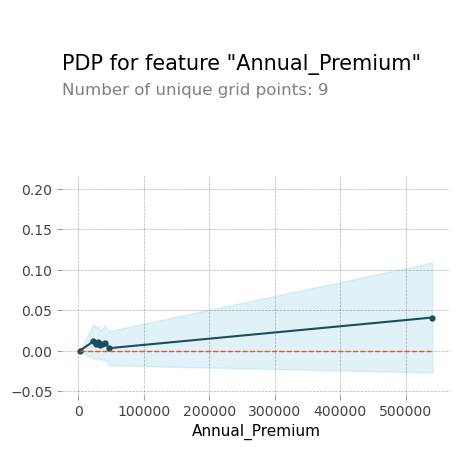

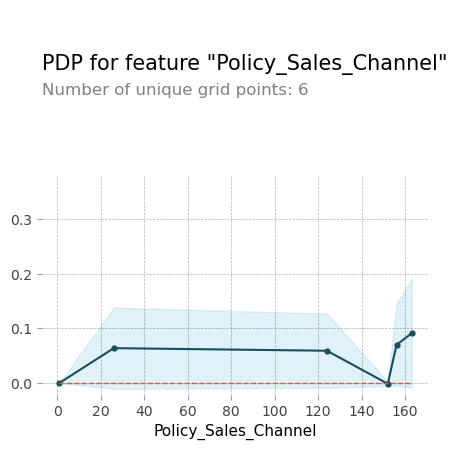

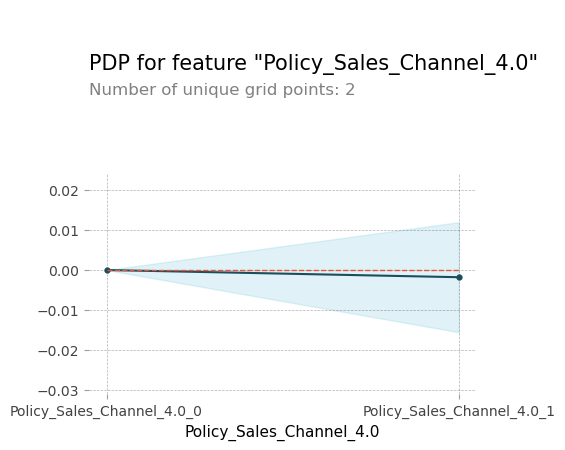

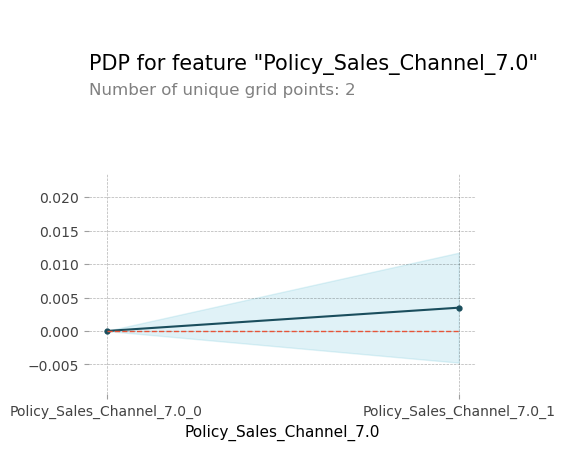

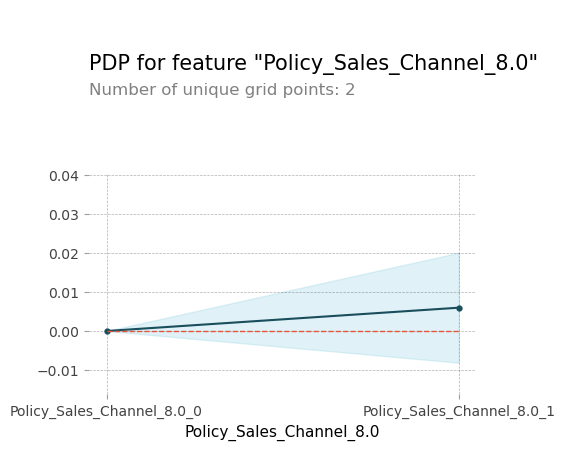

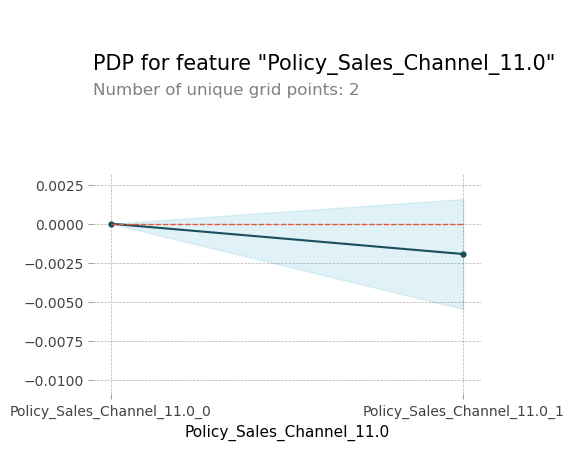

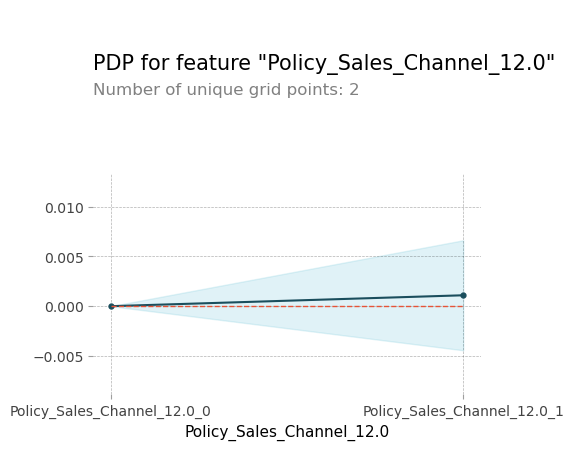

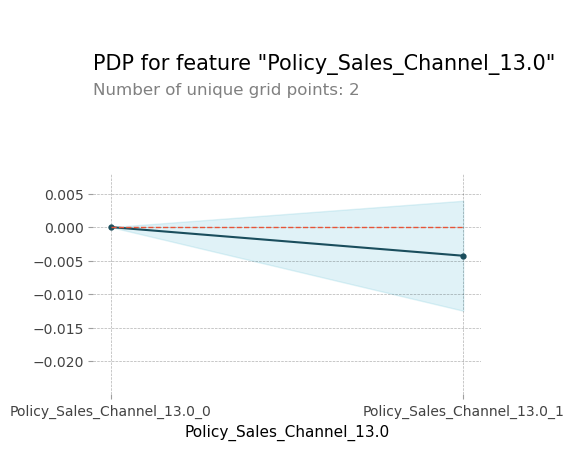

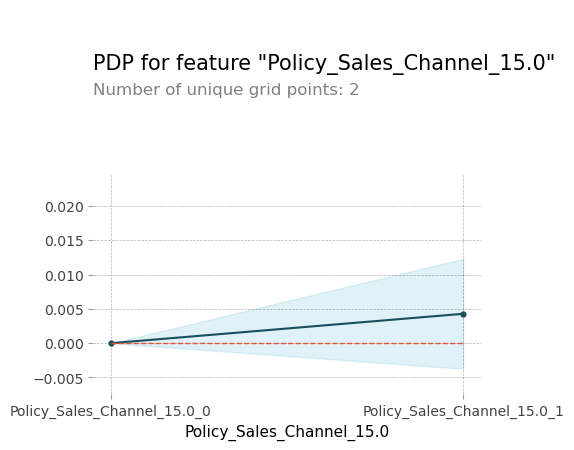

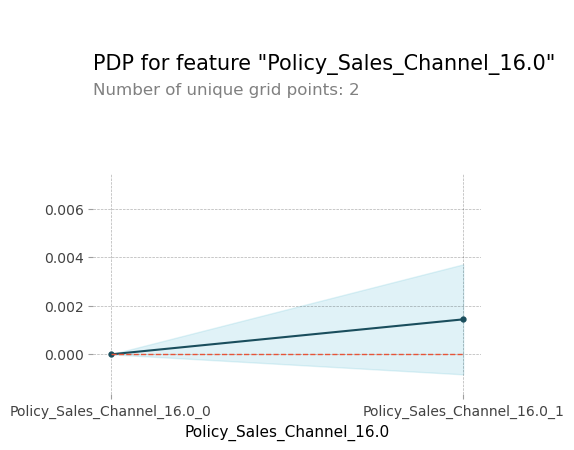

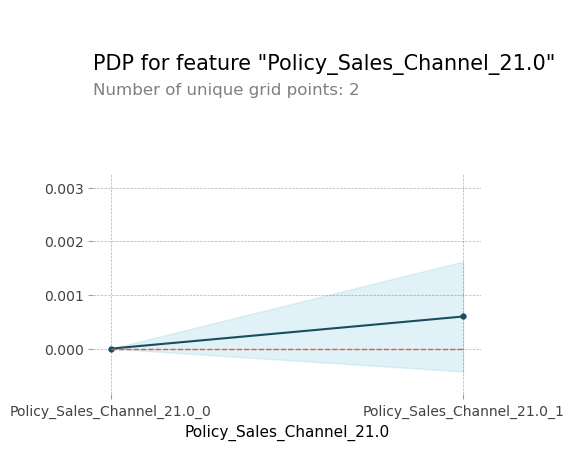

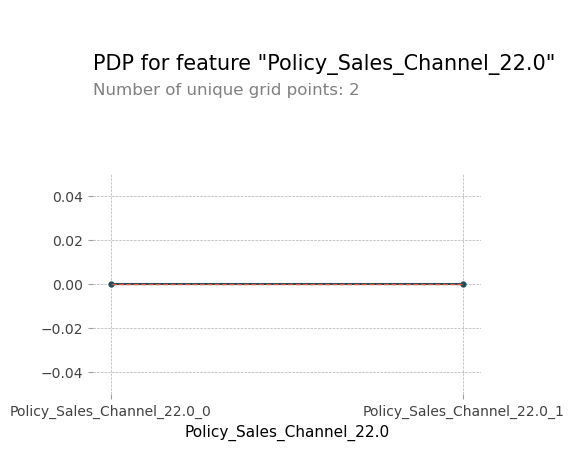

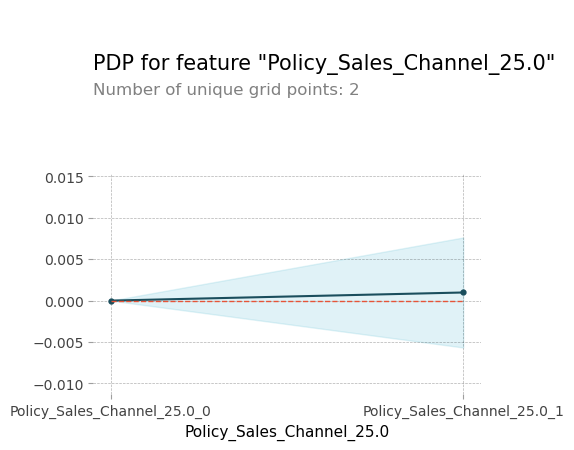

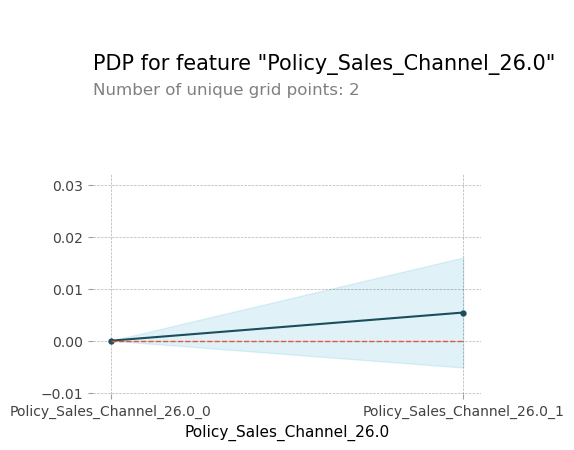

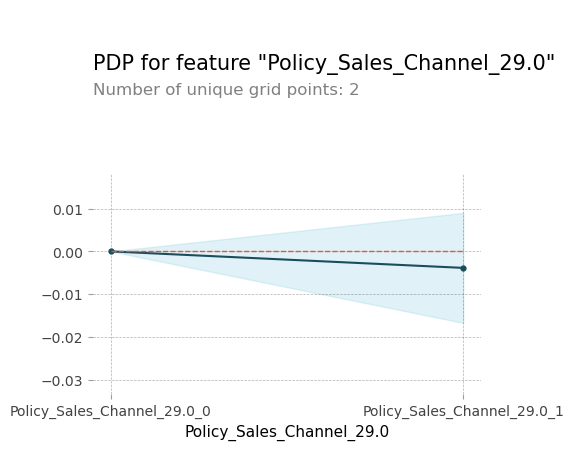

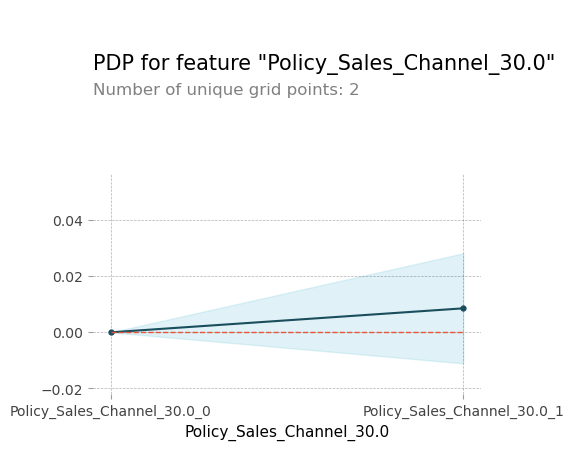

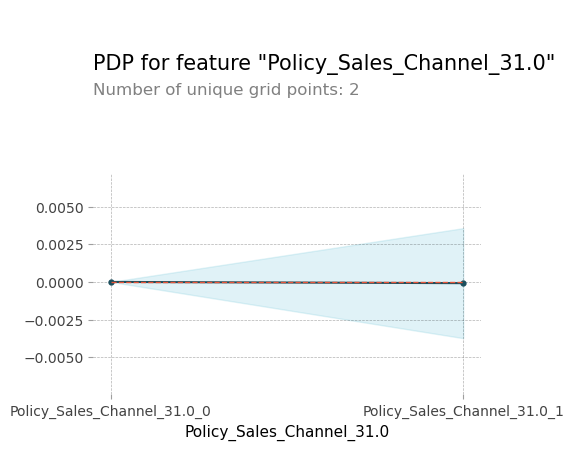

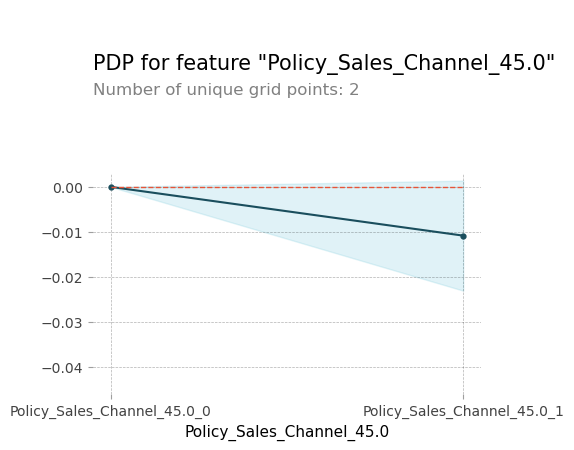

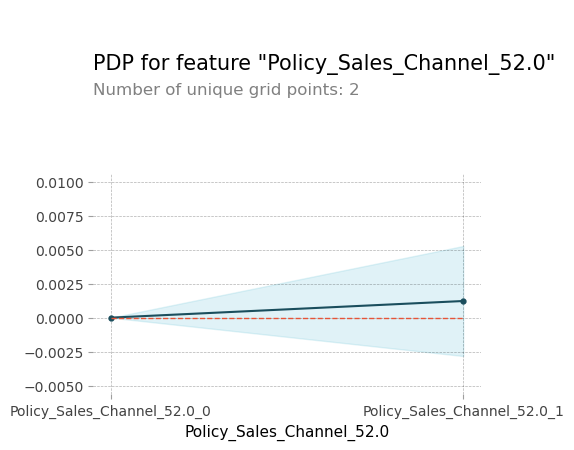

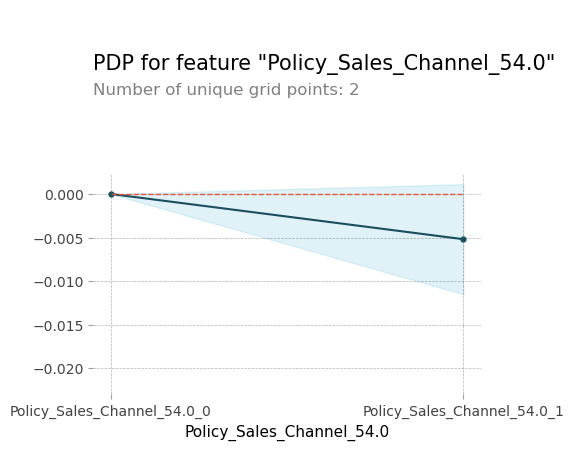

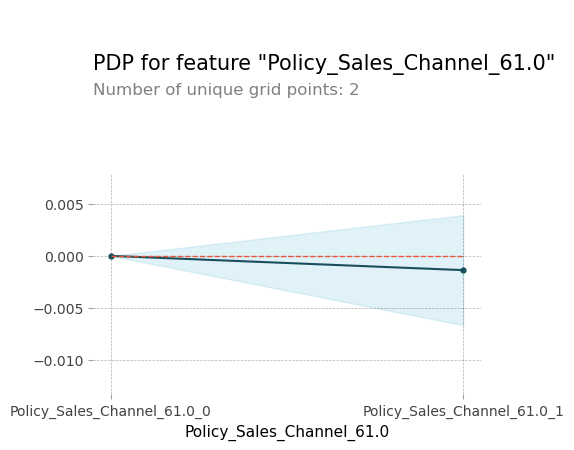

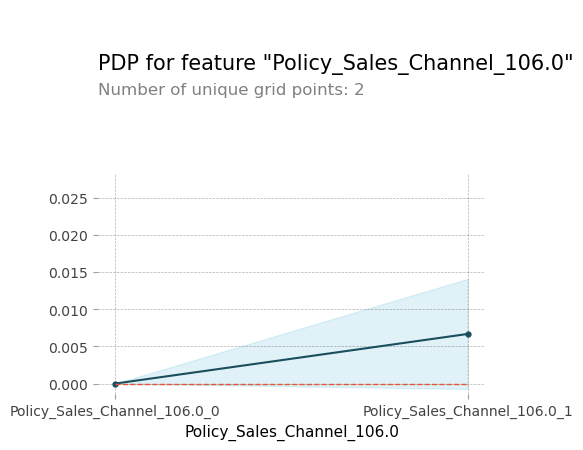

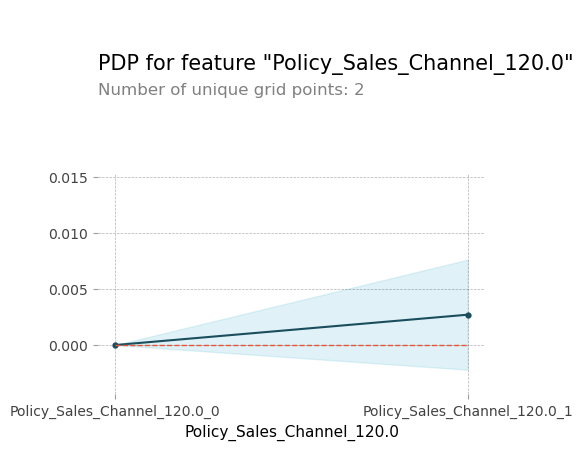

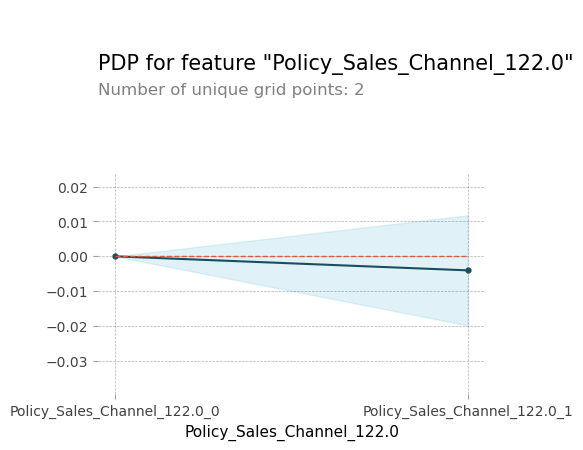

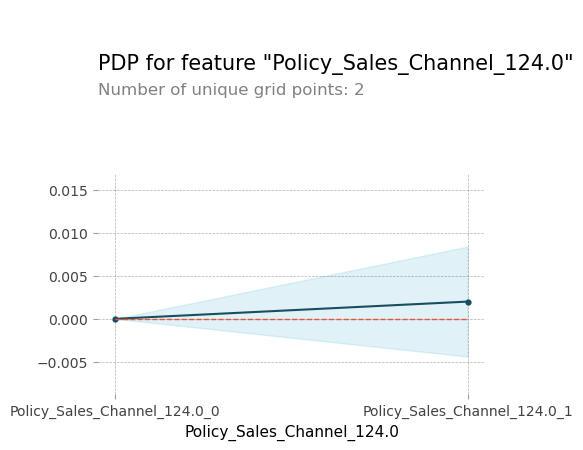

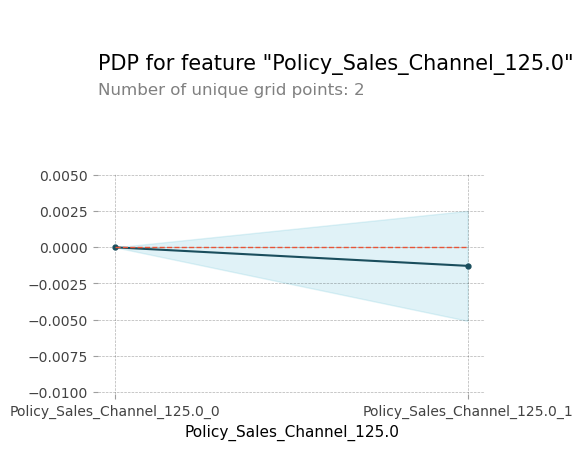

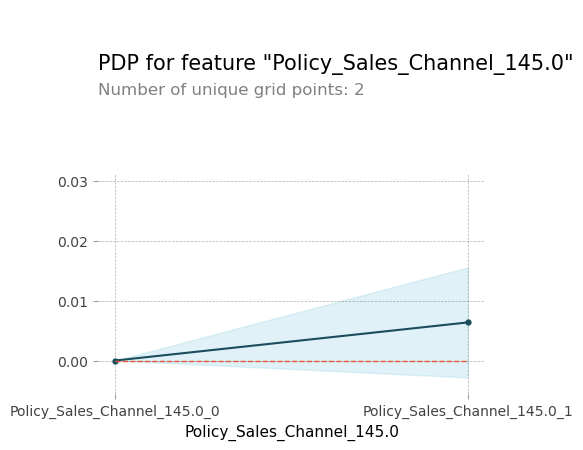

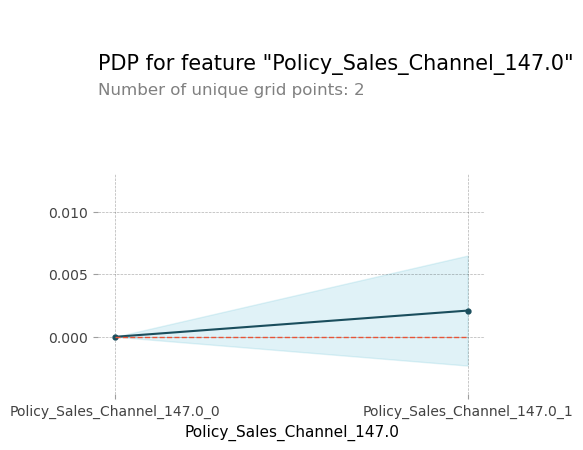

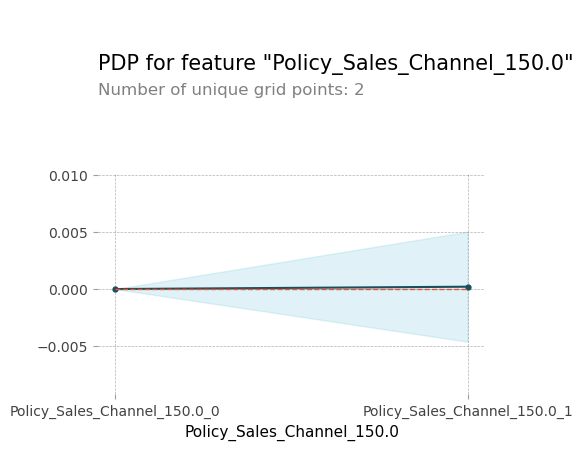

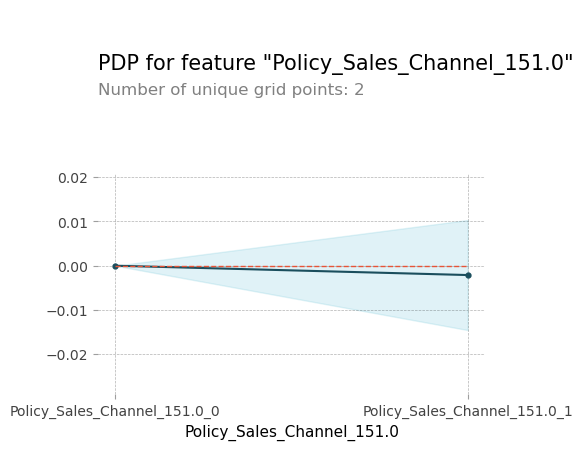

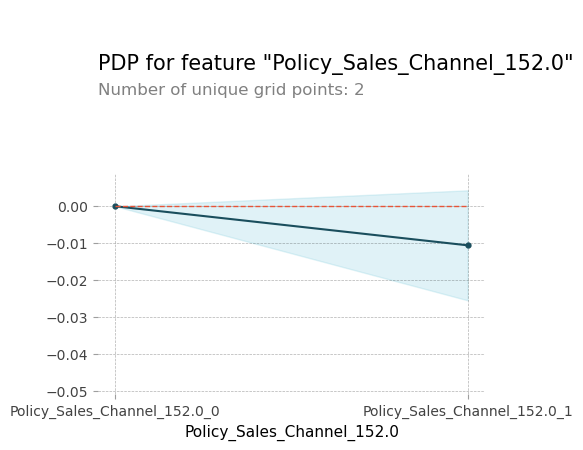

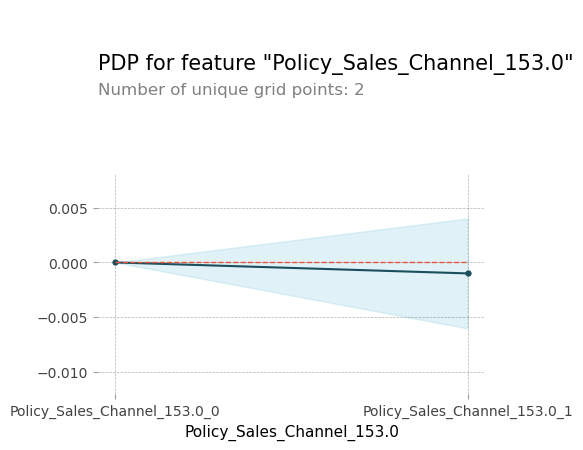

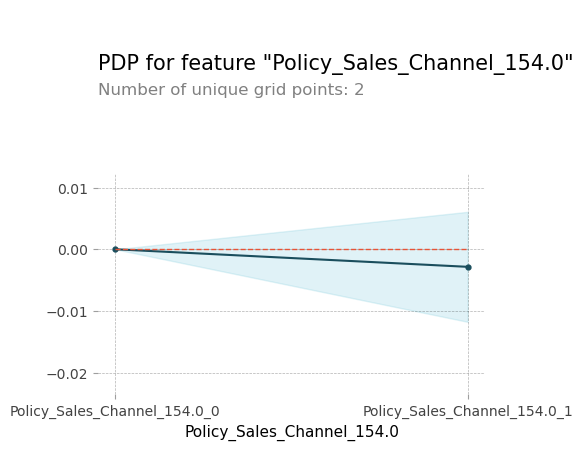

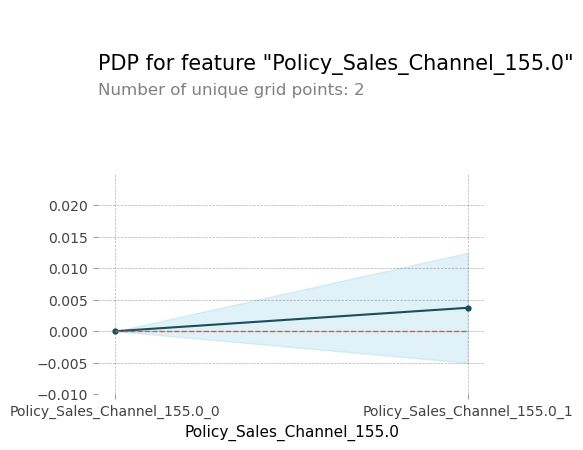

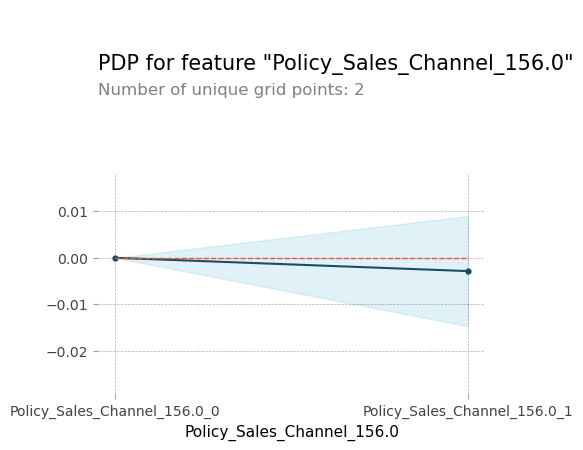

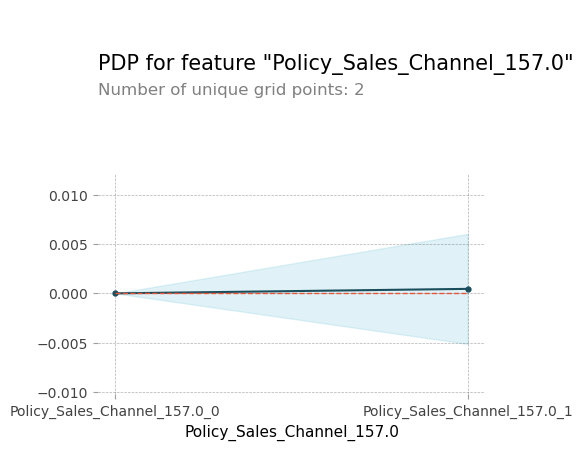

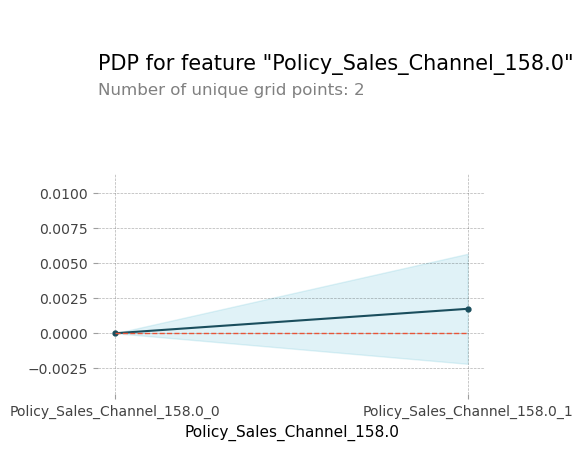

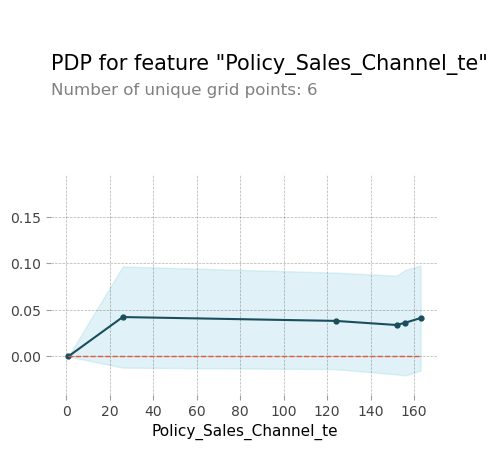

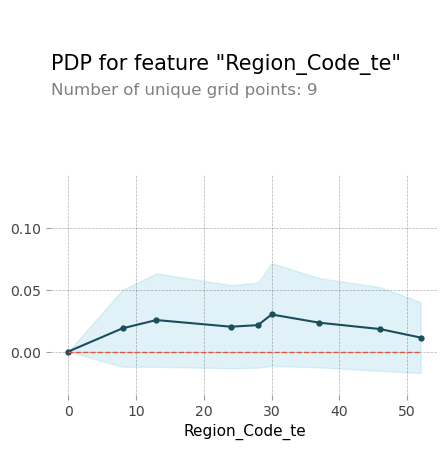

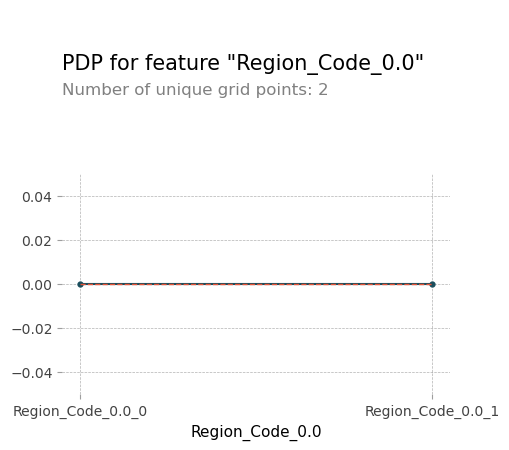

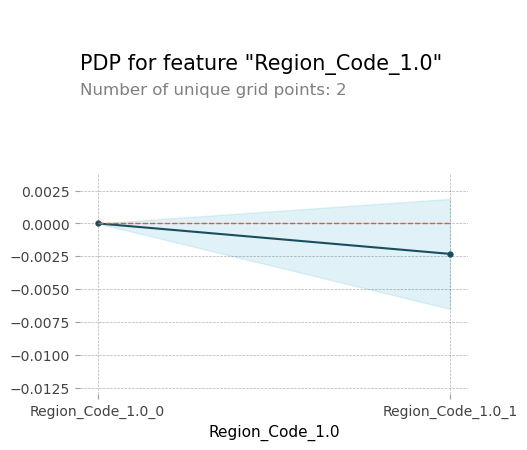

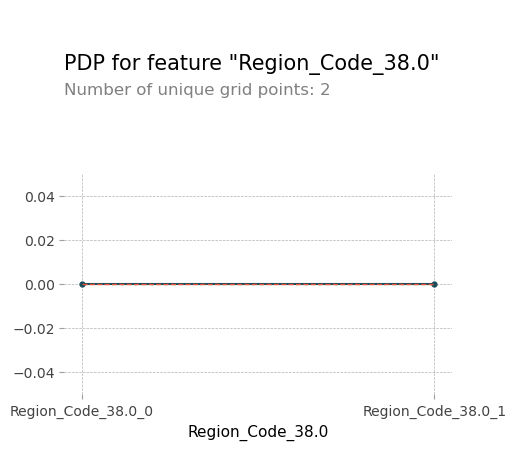

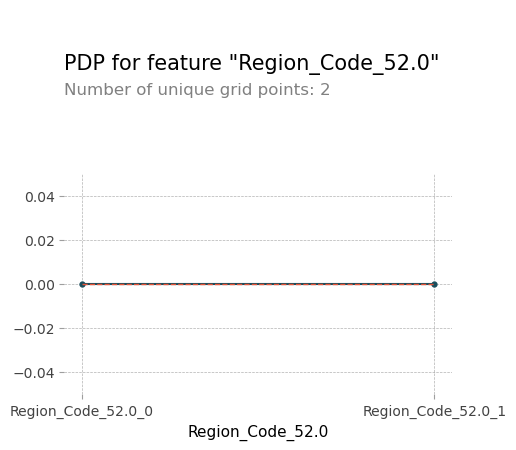

In [25]:
from pdpbox import pdp, get_dataset, info_plots

feature_names = X_reduce_te.columns.values.tolist()
for selected_feature in feature_names:
    pdp_isolated = pdp.pdp_isolate(model=model, dataset=X_reduce_te, model_features=feature_names, feature=selected_feature)
    pdp.pdp_plot(pdp_isolated, selected_feature, figsize=(5,5))
    plt.show()

In [ ]:
# TODO: choose most interesting plots and describe

# >= 0.1
# Age
# Previously_Insured
# Vehicle_Damage
# Policy_Sales_Channel_11

# >= 0.01
# Region_Code
# Vehicle_Age
# Annual_Premium
# Policy_Sales_Channel
